### Data Download

In [ ]:
import kagglehub
import os
import shutil

# Dataset directory
dataset_dir = "data/raw"

# Download dataset
path = kagglehub.dataset_download("jiayuanchengala/aid-scene-classification-datasets")
src_dir = os.path.join(path, "AID")

# Move only if not already moved
if not os.path.exists(dataset_dir):
    print("Copying dataset to data/raw...")
    # Note that if I move it then kagglehub wont re-download so we can=t keep consistency
    shutil.copytree(src_dir, dataset_dir)
else:
    print("Dataset already exists at data/raw")

print("✅ Dataset ready at:", dataset_dir)


### Manual Data Separation

Note that this isn't necessary for sklearn since it already includes splits and cross validation.

However, for deep learning (Pytorch) you do need to the separation yourself

In [2]:
import os


image_paths =  []
labels = []
source_dir = 'data/raw'
categories = [d for d in os.listdir(source_dir)
              if os.path.isdir(os.path.join(source_dir, d))]
for category in categories:
    category_path = os.path.join(source_dir, category)
    files = [os.path.join(category_path, f) for f in os.listdir(category_path)
             if os.path.isfile(os.path.join(category_path, f))]
    image_paths.extend(files)
    labels.extend([category] * len(files))

print(f"Found {len(image_paths)} images in {len(categories)} categories")
os.makedirs("metrics", exist_ok=True)

Found 10000 images in 30 categories


In [ ]:
import random
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# Source directory containing all the category folders
source_dir = 'data/raw'

# Create train and test directories
train_dir = 'data/train'
test_dir = 'data/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category in categories:
    category_path = os.path.join(source_dir, category)

    if not os.path.exists(category_path):
        print(f"Warning: {category} folder not found, skipping...")
        continue

    # Get all files in the category folder
    files = [f for f in os.listdir(category_path)
             if os.path.isfile(os.path.join(category_path, f))]

    if len(files) == 0:
        print(f"Warning: {category} folder is empty, skipping...")
        continue

    # Shuffle files randomly
    random.shuffle(files)

    # Calculate split point (90% for train)
    split_idx = int(len(files) * 0.9)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # Create category subfolders in train and test
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # Move files to train
    for file in train_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(train_category_dir, file)
        shutil.copy2(src, dst)

    # Move files to test
    for file in test_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(test_category_dir, file)
        shutil.copy2(src, dst)

    print(f"{category}: {len(train_files)} files to train, {len(test_files)} files to test")

print("\nSplit complete!")

In [ ]:
from collections import defaultdict

# This is for cross-validation (Pytorch and Tensorflow need manual separation)
# To scikit-learning you onl need to pass the training data and it does the division

# Configuration
k_folds = 5
output_base = 'kfolds'
os.makedirs(output_base, exist_ok=True)

print(f"Creating {k_folds}-fold cross-validation split...")

# Collect all files by category
category_files = {}
for category in categories:
    category_path = os.path.join(source_dir, category)
    files = [f for f in os.listdir(category_path)
             if os.path.isfile(os.path.join(category_path, f))]
    random.shuffle(files)  # Shuffle within each category
    category_files[category] = files

# Create fold assignments for each category
fold_assignments = defaultdict(lambda: defaultdict(list))

for category, files in category_files.items():
    n_files = len(files)
    fold_size = n_files // k_folds

    # Assign files to folds ensuring balanced distribution
    for fold_idx in range(k_folds):
        start_idx = fold_idx * fold_size
        # Last fold gets any remaining files
        end_idx = start_idx + fold_size if fold_idx < k_folds - 1 else n_files
        fold_assignments[fold_idx][category] = files[start_idx:end_idx]

# Create fold directories with class subdirectories only
for fold_idx in range(k_folds):
    fold_name = f'fold_{fold_idx + 1}'
    fold_dir = os.path.join(output_base, fold_name)

    # Create class subdirectories in each fold
    for category in categories:
        category_fold_dir = os.path.join(fold_dir, category)
        os.makedirs(category_fold_dir, exist_ok=True)

        # Copy the files assigned to this fold for this category
        files_for_this_fold = fold_assignments[fold_idx][category]

        for file in files_for_this_fold:
            src = os.path.join(source_dir, category, file)
            dst = os.path.join(category_fold_dir, file)
            shutil.copy2(src, dst)

    print(f"\n{fold_name}:")
    print("=" * 50)

    total_files = 0
    for category in categories:
        files_in_fold = fold_assignments[fold_idx][category]
        total_files += len(files_in_fold)
        print(f"  {category}: {len(files_in_fold)} files")

    print(f"  Total in fold: {total_files} files")

print(f"\n\nK-fold split complete!")
print(f"Output directory: {output_base}/")
print(f"Structure: fold_1/, fold_2/, ..., fold_{k_folds}/")
print(f"Each fold contains: {', '.join(categories)} subdirectories with their respective files")

print(f"\n\nK-fold split complete!")
print(f"Output directory: {output_base}/")
print(f"Structure: fold_1/, fold_2/, ..., fold_{k_folds}/")

### Bag of Visual Words

Since Bag of Features consist on 4 stages we decide to use classes to not hardcode each possible combination.

We separate them into descriptorExtractor class which is meant to be used in the first step of the Bag of Visual Word which is extracting the features.

For the clustering step we would usually simply keep always MiniBatchKMeans since it is the most scalable and faster than KMeans with similar accuracy; however, because we are keeping both in a class for a more theoretical approach where we can compare both

Then the encoding part consist on how you analyze the clusters given an image. The original implementation is only with histograms, however, there are some alternatives like VLAD or Fisher vector that we also considered to take into account (to know difference between them in both accuracy and memory). Note that they are considered different algorithms and usually not considered part of BoVW but we decided to classify as encoding class because it doesn't break Bag of Features structure

Lastly is the pipeline which could be removed and do training and classifier with the encoders and independent classifiers. However, you can see that the best scalable approach in sklearn are pipelines; however, they are not meant to be used for image classification by default, so we adapt them to be able to follow Bag of Features algorithm  while keeping sklearning advantages (which are fitting, predicting and saving/loading models with joblib)

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import normalize
from abc import ABC, abstractmethod
from typing import Optional
from enum import Enum
import cv2 as cv


class DescriptorType(Enum):
    """Enum for available descriptor types."""
    SIFT = "SIFT"
    ORB = "ORB"
    AKAZE = "AKAZE"


class DescriptorExtractor:
    """
    Unified interface for different feature descriptors.

    This class handles the quirks of different OpenCV detectors
    and provides a consistent interface.

    Parameters
    ----------
    descriptor_type : str or DescriptorType
        Type of descriptor to use ('SIFT', 'ORB', 'AKAZE', etc.)
    n_features : int, optional
        Maximum number of features to detect (for SIFT, ORB)
    **kwargs : dict
        Additional parameters for the specific detector
    """

    def __init__(
        self,
        descriptor_type: str = 'SIFT',
        n_features: Optional[int] = None,
        **kwargs
    ):
        self.descriptor_type = descriptor_type.upper()
        self.n_features = n_features
        self.kwargs = kwargs
        self.detector = self._create_detector()
        self.descriptor_size = self._get_descriptor_size()

    def _create_detector(self):
        """Create the appropriate OpenCV detector."""
        dt = self.descriptor_type

        if dt == 'SIFT':
            if self.n_features is not None:
                return cv.SIFT_create(nfeatures=self.n_features, **self.kwargs)
            return cv.SIFT_create(**self.kwargs)

        elif dt == 'ORB':
            if self.n_features is not None:
                return cv.ORB_create(nfeatures=self.n_features, **self.kwargs)
            return cv.ORB_create(**self.kwargs)

        elif dt == 'AKAZE':
            return cv.AKAZE_create(**self.kwargs)

        else:
            raise ValueError(
                f"Unknown descriptor type: {dt}. "
                f"Available: {[e.value for e in DescriptorType]}"
            )

    def _get_descriptor_size(self) -> int:
        """Get the descriptor dimensionality for each type."""
        size_map = {
            'SIFT': 128,
            'ORB': 32,
            'AKAZE': 61
        }
        return size_map.get(self.descriptor_type, 128)

    def extract(
        self,
        image: np.ndarray,
        return_keypoints: bool = False
    ) -> np.ndarray:
        """
        Extract descriptors from an image array.

        Parameters
        ----------
        image : np.ndarray
            Input image (grayscale or color)
        return_keypoints : bool, default=False
            If True, return (keypoints, descriptors) tuple

        Returns
        -------
        descriptors : np.ndarray
            Descriptor array of shape (n_keypoints, descriptor_size)
            Returns empty array if no keypoints detected
        """
        if len(image.shape) == 3:
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        keypoints, descriptors = self.detector.detectAndCompute(image, None)

        if descriptors is None or len(keypoints) == 0:
            descriptors = np.zeros((0, self.descriptor_size), dtype=np.float32)
            keypoints = []
        else:
            descriptors = descriptors.astype(np.float32)

        if return_keypoints:
            return keypoints, descriptors
        return descriptors

    def extract_from_file(
        self,
        filepath: str,
        return_keypoints: bool = False
    ) -> np.ndarray:
        """
        Extract descriptors from an image file.

        Parameters
        ----------
        filepath : str
            Path to image file
        return_keypoints : bool, default=False
            If True, return (keypoints, descriptors) tuple

        Returns
        -------
        descriptors : np.ndarray
            Descriptor array or empty array if file can't be read
        """
        image = cv.imread(str(filepath), cv.IMREAD_GRAYSCALE)

        if image is None:
            empty_desc = np.zeros((0, self.descriptor_size), dtype=np.float32)
            if return_keypoints:
                return [], empty_desc
            return empty_desc

        return self.extract(image, return_keypoints=return_keypoints)

    def extract_batch(
        self,
        images: list,
        from_files: bool = False
    ) -> list:
        """
        Extract descriptors from multiple images.

        Parameters
        ----------
        images : list
            List of image arrays or file paths
        from_files : bool, default=False
            If True, treat images as file paths

        Returns
        -------
        list of np.ndarray
            List of descriptor arrays
        """
        if from_files:
            return [self.extract_from_file(img) for img in images]
        else:
            return [self.extract(img) for img in images]

    def load_descriptors(self, filepath: str):
        """Load descriptors from a .npy file."""
        descriptors = np.load(filepath, allow_pickle=True)
        if descriptors is None or descriptors.size == 0:
            return None

        descriptors = np.asarray(descriptors, dtype=np.float32)

        if descriptors.ndim != 2 or descriptors.shape[1] != 128:
            return None

        return descriptors

    def __repr__(self):
        return (
            f"DescriptorExtractor(type={self.descriptor_type}, "
            f"n_features={self.n_features}, "
            f"descriptor_size={self.descriptor_size})"
        )

    def __getstate__(self):
        state = self.__dict__.copy()
        state.pop('detector', None)
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        try:
            if hasattr(self, 'descriptor_type') and self.descriptor_type in ('SIFT', 'ORB', 'AKAZE'):
                self.detector = self._create_detector()
            else:
                self.detector = None
        except Exception:
            self.detector = None


class ClusteringAlgorithm(ABC):
    """Base class for clustering algorithms."""

    def __init__(self, n_clusters: int, random_state: int = 42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self._model = None
        self._is_fitted = False

    @abstractmethod
    def fit(self, X: np.ndarray):
        pass

    @abstractmethod
    def fit_iterative(self, data_loader, load_func: Optional[callable] = None):
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not self._is_fitted:
            raise ValueError("Model must be fitted before predicting.")
        return self.model.predict(X)

    @property
    def cluster_centers_(self) -> np.ndarray:
        if not self._is_fitted:
            raise ValueError("Model must be fitted first.")
        return self.model.cluster_centers_

    def descriptor_batch_generator(self,
    data_loader, load_func=None, max_descriptors=10000):
        """
        Yields batches of descriptors with a total number of rows up to max_descriptors.

        Args:
            data_loader: iterable of items to load descriptors from.
            load_func: optional function(item) -> descriptor array
            max_descriptors: max total rows per batch

        Yields:
            np.ndarray of shape (~max_descriptors, n_features)
        """
        batch = []
        current_size = 0

        for item in data_loader:
            data = load_func(item) if load_func else item

            if data is None or data.size == 0:
                continue

            if data.ndim == 1:
                data = data.reshape(1, -1)

            batch.append(data)
            current_size += data.shape[0]

            if current_size >= max_descriptors:
                yield np.vstack(batch)
                batch = []
                current_size = 0

        if batch:
            yield np.vstack(batch)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith("_")
        }

    def to_dict(self):
        """Return a dictionary representation of the clustering configuration."""
        return {
            'type': self.__class__.__name__,
            'n_clusters': self.n_clusters,
            'random_state': self.random_state,
            'is_fitted': self._is_fitted
        }

    def __repr__(self):
        params = ', '.join(f"{k}={v!r}" for k, v in self.to_dict().items() if k != 'type')
        return f"{self.__class__.__name__}({params})"


class MiniBatchKMeansClustering(ClusteringAlgorithm):
    """MiniBatch KMeans with support for iterative fitting."""

    def __init__(self, n_clusters: int, batch_size: int = 1024, random_state: int = 42, **kwargs):
        super().__init__(n_clusters, random_state)
        self.batch_size = batch_size
        self.kwargs = kwargs
        self.model = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=random_state,
            **kwargs
        )

    def fit(self, X: np.ndarray):
        self.model.fit(X)
        self._is_fitted = True
        return self

    def fit_iterative(
        self,
        data_loader,
        load_func: Optional[callable] = None,
        accumulate_batch_size: Optional[int] = None
    ):
        """
        Fit iteratively using partial_fit.

        Args:
            data_loader: Iterable of file paths or data chunks
            load_func: Function to load data from paths
            accumulate_batch_size: Size to accumulate before partial_fit
                                   (defaults to self.batch_size)
        """
        if accumulate_batch_size is None:
            accumulate_batch_size = self.batch_size

        for batch in self.descriptor_batch_generator(data_loader, load_func, accumulate_batch_size):
            self.model.partial_fit(batch)

        self._is_fitted = True
        return self

    def to_dict(self):
        """Return a dictionary representation including batch_size."""
        base_dict = super().to_dict()
        base_dict['batch_size'] = self.batch_size
        return base_dict


class KMeansClustering(ClusteringAlgorithm):
    """Standard KMeans clustering."""

    def __init__(self, n_clusters: int, random_state: int = 0, **kwargs):
        super().__init__(n_clusters, random_state)
        self.kwargs = kwargs
        self.model = KMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            **kwargs
        )

    def fit(self, X: np.ndarray):
        """Fit KMeans on all data at once."""
        self.model.fit(X)
        self._is_fitted = True
        return self

    def fit_iterative(self, data_loader, load_func: Optional[callable] = None):
        """KMeans doesn't support iterative fitting - loads all data first."""
        print("Warning: KMeans doesn't support true iterative fitting. Loading all data...")

        all_data = []
        for item in data_loader:
            data = load_func(item) if load_func else item
            if data is not None and data.size > 0:
                all_data.append(data)

        if all_data:
            X = np.vstack(all_data)
            self.fit(X)
        return self


class EncodingAlgorithm(ABC):
    """Base class for encoding algorithms."""

    def __init__(self, clustering: ClusteringAlgorithm):
        self.clustering = clustering

    @abstractmethod
    def encode(self, descriptors: np.ndarray) -> np.ndarray:
        pass

    def to_dict(self):
        """Return a dictionary representation including clustering info."""
        return {
            'type': self.__class__.__name__,
            'clustering': self.clustering.to_dict()
        }

    def __repr__(self):
        return f"{self.__class__.__name__}(clustering={self.clustering!r})"


class BagOfVisualWords(EncodingAlgorithm):
    """Bag of Visual Words encoding."""

    def __init__(self, clustering: ClusteringAlgorithm,
                 normalize_hist: bool = True,
                 norm_type: str = 'l2'):
        super().__init__(clustering)
        self.normalize_hist = normalize_hist
        self.norm_type = norm_type

    def encode(self, descriptors: np.ndarray) -> np.ndarray:
        if descriptors is None or descriptors.size == 0:
            return np.zeros(self.clustering.n_clusters)

        labels = self.clustering.predict(descriptors)
        histogram = np.bincount(labels, minlength=self.clustering.n_clusters).astype(np.float32)

        if self.normalize_hist:
            if self.norm_type == 'l2':
                norm = np.linalg.norm(histogram)
                if norm > 0:
                    histogram = histogram / norm
            elif self.norm_type == 'l1':
                if histogram.sum() > 0:
                    histogram = histogram / histogram.sum()

        return histogram

    def to_dict(self):
        """Return a dictionary representation including normalization info."""
        base_dict = super().to_dict()
        base_dict['normalize_hist'] = self.normalize_hist
        base_dict['norm_type'] = self.norm_type
        return base_dict

    def __repr__(self):
        return (f"{self.__class__.__name__}("
                f"normalize={self.normalize_hist}, "
                f"norm_type={self.norm_type!r}, "
                f"clustering={self.clustering!r})")


class VLAD(EncodingAlgorithm):
    """Vector of Locally Aggregated Descriptors."""

    def __init__(self, clustering: ClusteringAlgorithm, normalize_vlad: bool = True):
        super().__init__(clustering)
        self.normalize_vlad = normalize_vlad

    def encode(self, descriptors: np.ndarray) -> np.ndarray:
        if descriptors is None or descriptors.size == 0:
            n_features = self.clustering.cluster_centers_.shape[1]
            return np.zeros(self.clustering.n_clusters * n_features)

        labels = self.clustering.predict(descriptors)
        centers = self.clustering.cluster_centers_
        n_clusters, n_features = centers.shape
        vlad = np.zeros((n_clusters, n_features))

        for idx in range(n_clusters):
            mask = (labels == idx)
            if np.any(mask):
                residuals = descriptors[mask] - centers[idx]
                vlad[idx] = residuals.sum(axis=0)

        vlad = vlad.flatten()
        vlad = vlad.reshape(n_clusters, n_features)
        vlad = normalize(vlad, norm='l2', axis=1)
        vlad = vlad.flatten()
        vlad = np.sign(vlad) * np.sqrt(np.abs(vlad))

        if self.normalize_vlad:
            vlad = normalize(vlad.reshape(1, -1), norm='l2').flatten()

        return vlad

    def to_dict(self):
        """Return a dictionary representation including normalization info."""
        base_dict = super().to_dict()
        base_dict['normalize_vlad'] = self.normalize_vlad
        return base_dict

    def __repr__(self):
        return (f"{self.__class__.__name__}("
                f"normalize={self.normalize_vlad}, "
                f"clustering={self.clustering!r})")


class VisualEncodingTransformer(BaseEstimator, TransformerMixin):
    """
    sklearn-compatible wrapper for visual encoding pipelines.

    This allows you to:
    - Save/load with joblib
    - Use in sklearn Pipelines
    - Use with GridSearchCV
    - Keep your flexible architecture

    Parameters
    ----------
    encoding : EncodingAlgorithm
        Custom encoding algorithm instance
    descriptor_extractor : callable, optional
        Function to extract descriptors from images
        Signature: descriptor_extractor(image_path) -> np.ndarray
    iterative_fit : bool, default=False
        If True, use iterative fitting (for large datasets)
    skip_clustering_fit: bool, default=False
        If True, skip fitting the clustering model
    """

    def __init__(
        self,
        encoding: EncodingAlgorithm,
        descriptor_extractor: Optional[callable] = None,
        iterative_fit: bool = False,
        skip_clustering_fit: bool = False
    ):
        self.encoding = encoding
        self.descriptor_extractor = descriptor_extractor
        self.iterative_fit = iterative_fit
        self.skip_clustering_fit = skip_clustering_fit

    @property
    def clustering(self):
        return self.encoding.clustering

    def fit(self, X, y=None):
        """
        Fit the clustering model.

        Parameters
        ----------
        X : array-like
            Either:
            - List of image paths (if descriptor_extractor is provided)
            - List of descriptor arrays
            - Single stacked array of all descriptors
        y : array-like, optional
            Target labels (unused, for sklearn compatibility)

        Returns
        -------
        self
        """
        if self.skip_clustering_fit:
            if not self.clustering._is_fitted:
                raise ValueError(
                    "skip_clustering_fit=True but clustering is not fitted! "
                    "Either fit the clustering first or set skip_clustering_fit=False"
                )
            print("Skipping clustering fit (using pre-fitted clusters)")
            return self

        if self.descriptor_extractor is not None:
            if self.iterative_fit:
                self.clustering.fit_iterative(X, load_func=self.descriptor_extractor)
            else:
                all_descriptors = []
                for path in X:
                    desc = self.descriptor_extractor(path)
                    if desc is not None and desc.size > 0:
                        all_descriptors.append(desc)
                if all_descriptors:
                    all_descriptors = np.vstack(all_descriptors)
                    self.clustering.fit(all_descriptors)
        else:
            if isinstance(X, list):
                X = np.vstack([d for d in X if d is not None and d.size > 0])
            self.clustering.fit(X)

        return self

    def transform(self, X):
        """
        Encode images/descriptors into fixed-length vectors.

        Parameters
        ----------
        X : array-like
            Either:
            - List of image paths (if descriptor_extractor is provided)
            - List of descriptor arrays (each image's descriptors)

        Returns
        -------
        np.ndarray
            Encoded vectors, shape (n_samples, encoding_dim)
        """
        if isinstance(X, str) or (hasattr(X, 'ndim') and X.ndim == 0):
            X = [X]
        elif hasattr(X, 'ndim') and X.ndim == 1 and X.dtype == object and len(X) == 0:
            pass
        elif not hasattr(X, '__iter__') or isinstance(X, (str, bytes)):
            X = [X]

        encoded = []

        for sample in X:
            descriptors = (self.descriptor_extractor(sample)
                        if self.descriptor_extractor is not None
                        else sample)
            encoded.append(self.encoding.encode(descriptors))

        return np.array(encoded)

    def get_params(self, deep=True):
        """Get parameters for sklearn compatibility."""
        params = {
            'clustering': self.clustering,
            'encoding': self.encoding,
            'descriptor_extractor': self.descriptor_extractor,
            'iterative_fit': self.iterative_fit
        }

        if deep and hasattr(self.clustering, 'get_params'):
            cluster_params = self.clustering.__dict__.copy()
            params.update({f'clustering__{k}': v for k, v in cluster_params.items()})

        return params

    def set_params(self, **params):
        """Set parameters for sklearn compatibility."""
        for key, value in params.items():
            if '__' in key:
                obj_name, param_name = key.split('__', 1)
                obj = getattr(self, obj_name)
                setattr(obj, param_name, value)
            else:
                setattr(self, key, value)
        return self

    def to_dict(self):
        """Return a dictionary representation of the entire pipeline."""
        return {
            'type': self.__class__.__name__,
            'encoding': self.encoding.to_dict(),
            'iterative_fit': self.iterative_fit,
            'skip_clustering_fit': self.skip_clustering_fit,
            'has_descriptor_extractor': self.descriptor_extractor is not None
        }

    def __repr__(self):
        extractor_info = (
            f"{self.descriptor_extractor.__class__.__name__}"
            if hasattr(self.descriptor_extractor, '__class__')
            else type(self.descriptor_extractor).__name__
        ) if self.descriptor_extractor else None

        return (
            f"{self.__class__.__name__}(\n"
            f"  encoding={self.encoding!r},\n"
            f"  descriptor_extractor={extractor_info},\n"
            f"  iterative_fit={self.iterative_fit}\n"
            f")"
        )


# ============================================================================
# Convenience Factory Functions
# ============================================================================

def create_bovw_pipeline(
    n_clusters: int = 512,
    batch_size: int = 1024,
    normalize: bool = True,
    descriptor_extractor: Optional[DescriptorExtractor] = None,
    iterative_fit: bool = False,
    clustering: Optional[ClusteringAlgorithm] = None
) -> VisualEncodingTransformer:
    """
    Create a BoVW encoding pipeline.

    Example:
        >>> extractor = DescriptorExtractor(descriptor_type='SIFT', n_features=500)
        >>> bovw = create_bovw_pipeline(
        ...     n_clusters=1024,
        ...     descriptor_extractor=extractor.extract_from_file
        ... )
        >>> bovw.fit(train_image_paths)
    """
    if clustering is None:
        clustering = MiniBatchKMeansClustering(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=42
        )
        skip_fit = False
    else:
        skip_fit = clustering._is_fitted
        if skip_fit:
            print(f"Using pre-fitted clustering with {clustering.n_clusters} clusters")

    encoding = BagOfVisualWords(clustering, normalize_hist=normalize)

    extract_func = None
    if descriptor_extractor is not None:
        if isinstance(descriptor_extractor, DescriptorExtractor):
            extract_func = descriptor_extractor.extract_from_file
        else:
            extract_func = descriptor_extractor

    return VisualEncodingTransformer(
        encoding=encoding,
        descriptor_extractor=extract_func,
        iterative_fit=iterative_fit,
        skip_clustering_fit=skip_fit
    )


def create_vlad_pipeline(
    n_clusters: int = 256,
    batch_size: int = 1024,
    normalize: bool = True,
    descriptor_extractor: Optional[DescriptorExtractor] = None,
    iterative_fit: bool = False,
    clustering: Optional[ClusteringAlgorithm] = None
) -> VisualEncodingTransformer:
    """Create a VLAD encoding pipeline."""
    if clustering is None:
        clustering = MiniBatchKMeansClustering(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=42
        )
        skip_fit = False
    else:
        skip_fit = clustering._is_fitted
        if skip_fit:
            print(f"Using pre-fitted clustering with {clustering.n_clusters} clusters")

    encoding = VLAD(clustering, normalize_vlad=normalize)

    extract_func = None
    if descriptor_extractor is not None:
        if isinstance(descriptor_extractor, DescriptorExtractor):
            extract_func = descriptor_extractor.extract_from_file
        else:
            extract_func = descriptor_extractor

    return VisualEncodingTransformer(
        encoding=encoding,
        descriptor_extractor=extract_func,
        iterative_fit=iterative_fit,
        skip_clustering_fit=skip_fit
    )


# **Training**

### Basic structure/Standard

In [4]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
# It is easier for metrics and evaluation to have encoded labels (numeric instead of strings)
labels_encoded = le.fit_transform(labels)

sift = DescriptorExtractor(descriptor_type='SIFT')
output_dir = "descriptors"
os.makedirs(output_dir, exist_ok=True)
for x in (image_paths):
  p = Path(x)
  output_path = os.path.join(output_dir,f"{p.stem}.npy")

  # Skip if the descriptor file already exists
  if os.path.exists(output_path):
    print(f"Skipping {x} — descriptors already saved at {output_path}")
    continue
  descriptors = sift.extract_from_file(x)

  np.save(output_path, descriptors)

# To test different algorithms we saved the descriptors to only extract them once
image_paths = [f"{output_dir}/{Path(x).stem}.npy" for x in image_paths]

# Note that stratify makes sure that the class distribution is maintained in train and test splits (important in classification tasks)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels_encoded, test_size=0.2, random_state=0, stratify=labels)

Skipping data/raw/BareLand/bareland_222.jpg — descriptors already saved at descriptors/bareland_222.npy
Skipping data/raw/BareLand/bareland_66.jpg — descriptors already saved at descriptors/bareland_66.npy
Skipping data/raw/BareLand/bareland_154.jpg — descriptors already saved at descriptors/bareland_154.npy
Skipping data/raw/BareLand/bareland_109.jpg — descriptors already saved at descriptors/bareland_109.npy
Skipping data/raw/BareLand/bareland_275.jpg — descriptors already saved at descriptors/bareland_275.npy
Skipping data/raw/BareLand/bareland_279.jpg — descriptors already saved at descriptors/bareland_279.npy
Skipping data/raw/BareLand/bareland_129.jpg — descriptors already saved at descriptors/bareland_129.npy
Skipping data/raw/BareLand/bareland_227.jpg — descriptors already saved at descriptors/bareland_227.npy
Skipping data/raw/BareLand/bareland_178.jpg — descriptors already saved at descriptors/bareland_178.npy
Skipping data/raw/BareLand/bareland_193.jpg — descriptors already 

## Cross-Validation / Tuning Parameters

This part is only meant to be run for calibrating and tuning the hyperparameters of models (like number of clusters, generalization (C), max-depth...)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Create sklearn-compatible transformer

# The one for cross-validation we need to fit in every fold (else it would leak data)
bovw_cv = create_bovw_pipeline(
    n_clusters=2048,
    descriptor_extractor=sift.load_descriptors,
    iterative_fit=True
)

# For single validation we could proceed to fit directly and re-separating the training data
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

# For this case we can simply fit one the whole training data and compare with the single validation fold
# clustering = MiniBatchKMeansClustering(
#     n_clusters=2048,
#     batch_size=10000
# )

# clustering.fit_iterative(
#     data_loader=X_train,
#     load_func=sift.load_descriptors
# )

# With this approach we highly reduce training time since we don't need to constantly fit the clustering in every fold
# bovw = create_bovw_pipeline(
#     clustering=clustering,
#     descriptor_extractor=sift.load_descriptors
# )

pipeline = Pipeline([
    ('encoding', bovw_cv),
    ('classifier',  # You can change the classifier here
     # For example SVM
    #  SVC(kernel='linear', C=1.0, random_state=42)
    # Or Softmax
    LogisticRegression( multi_class='multinomial',  # for multiclass classification (Softmax)
            solver='lbfgs',
            max_iter=500
    ))
])

In [ ]:
# Cross validation can also be done manually where you see each fold explicitly
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
accuracies = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = [X_train[i] for i in train_idx], [X_train[i] for i in val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Fit the pipeline
    pipeline.fit(X_tr, y_tr)

    # Evaluate
    test_accuracy = pipeline.score(X_val, y_val)
    train_accuracy = pipeline.score(X_tr, y_tr)
    accuracies.append([train_accuracy, test_accuracy])
    print(f"Fold Train accuracy: {train_accuracy:.4f}")
    print(f"Fold Validation Accuracy: {test_accuracy:.4f}")

print("\nCross-validation results:")
accuracies = np.array(accuracies)
print(f"Mean Train: {accuracies[:,0].mean():.4f} ± {accuracies[:,0].std():.4f}")
print(f"Mean Val: {accuracies[:,1].mean():.4f} ± {accuracies[:,1].std():.4f}")
print(f"Overfit: {accuracies[:,0].mean() - accuracies[:,1].mean():.4f}")

# Production Ready

This part is only meant to be run once after you have already defined the best hyperparameter for the models

It generates metrics data and safe models pipeline to be used to predict other dataset

## Metrics

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
import time
import joblib


def evaluate_model(
    pipeline, model_name,
    X_train, y_train,
    X_test, y_test,
    le,
    verbose=True,
    save_model_path=None,
    save_func=None
):
    """
    Train and evaluate a single model.
    Returns: dict of metrics, predictions, pipeline, and timing info.
    """

    # Train
    if verbose:
        print(f"\n{'='*60}")
        print(f"Training: {model_name}")
        print(f"{'='*60}")

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    if verbose:
        print(f"✓ Trained in {train_time:.2f}s")

    # Predict
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    inference_time = (time.time() - start_time) / len(X_test)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall    = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1        = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    overfit   = train_acc - test_acc

    # Try probabilities & ROC-AUC
    try:
        y_proba = pipeline.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    except Exception:
        y_proba = None
        roc_auc = np.nan

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    results = {
        'model_name': model_name,
        'pipeline': pipeline,
        'train_time': train_time,
        'inference_time_ms': inference_time * 1000,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'overfit': overfit,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_proba,
        'confusion_matrix': cm,
        'X_test': X_test,
        'label_encoder': le
    }

    if verbose:
        print(f"\n{'─'*60}")
        print(f"  {model_name} - Summary")
        print(f"{'─'*60}")
        print(f"  Train Acc:   {train_acc:.4f}")
        print(f"  Test Acc:    {test_acc:.4f}")
        print(f"  Precision:   {precision:.4f}")
        print(f"  Recall:      {recall:.4f}")
        print(f"  F1:          {f1:.4f}")
        if not np.isnan(roc_auc):
            print(f"  ROC-AUC:     {roc_auc:.4f}")
        print(f"  Overfit:     {overfit:.4f}")
        print(f"  Train Time:  {train_time:.2f}s")
        print(f"  Inference:   {inference_time * 1000:.3f}ms/sample")
        print(f"{'─'*60}\n")

    # Save model if requested
    if save_model_path:
        original_descriptor_extractor = None
        encoding_step = None

        # Locate the encoding step and save original descriptor_extractor
        for name, step in pipeline.steps:
            if hasattr(step, 'descriptor_extractor'):
                encoding_step = step
                original_descriptor_extractor = step.descriptor_extractor
                break

        if encoding_step is not None and save_func is not None:
            # Patch temporarily
            encoding_step.descriptor_extractor = save_func
            if verbose:
                print(f"✓ Updated descriptor extractor to {save_func.__name__}")
        elif verbose:
            print("⚠ Warning: No step with 'descriptor_extractor' found!" if encoding_step is None else
                "⚠ Warning: save_func is None — skipping patch.")

        try:
            model_bundle = {
                'pipeline': pipeline,
                'label_encoder': le
            }
            joblib.dump(model_bundle, save_model_path)
            if verbose:
                print(f"✓ Model saved to {save_model_path}")
        finally:
            # Always restore original, even on error
            if encoding_step is not None and original_descriptor_extractor is not None:
                encoding_step.descriptor_extractor = original_descriptor_extractor
                if verbose:
                    print("✓ Restored original descriptor extractor.")

    return results

def plot_confusion_matrix(results, normalize=False, figsize=(10, 8), save_path=None):
    cm = results['confusion_matrix']
    le = results['label_encoder']

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = f"{results['model_name']}\nNormalized Confusion Matrix"
    else:
        fmt = 'd'
        title = f"{results['model_name']}\nConfusion Matrix - Test accuracy {results['test_accuracy']:.4f}"

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to {save_path}")

    plt.show()


def plot_roc_curve(results, figsize=(12, 5), save_path=None):
    y_proba = results['y_proba']
    if y_proba is None:
        print("⚠ Skipping ROC: model doesn’t support predict_proba()")
        return

    y_test = results['y_test']
    le = results['label_encoder']
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fpr = dict()
    tpr = dict()

    # Compute per-class ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = np.trapz(mean_tpr, all_fpr)

    # Plot
    ax = axes[0]
    ax.plot(all_fpr, mean_tpr, linewidth=3, label=f'Macro-avg (AUC={macro_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
    ax.set_xlabel('FPR', fontweight='bold')
    ax.set_ylabel('TPR', fontweight='bold')
    ax.set_title(f"{results['model_name']}\nMacro-Average ROC", fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

    # Per-class (top 10)
    ax = axes[1]
    for i in range(min(n_classes, 10)):
        auc_i = np.trapz(tpr[i], fpr[i])
        ax.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} ({auc_i:.2f})', linewidth=1.5)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('FPR', fontweight='bold')
    ax.set_ylabel('TPR', fontweight='bold')
    ax.set_title(f"{results['model_name']}\nPer-Class ROC", fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to {save_path}")
    plt.show()

def print_classification_report(results):
    y_test, y_pred = results['y_test'], results['y_pred']
    le = results['label_encoder']
    print(f"\n{'='*70}")
    print(f"Classification Report: {results['model_name']}")
    print(f"{'='*70}\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

## Models

In [6]:
import os
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

clustering_bovw = MiniBatchKMeansClustering(
    n_clusters=512,
    batch_size=10000
)

clustering_bovw.fit_iterative(
    data_loader=X_train,
    load_func=sift.load_descriptors
)

clustering_vlad = MiniBatchKMeansClustering(
    n_clusters=8,
    batch_size=10000
)

clustering_vlad.fit_iterative(
    data_loader=X_train,
    load_func=sift.load_descriptors
)

# With this approach we highly reduce training time since we don't need to constantly fit the clustering in every fold
bovw = create_bovw_pipeline(
    clustering=clustering_bovw,
    descriptor_extractor=sift.load_descriptors
)

vlad = create_vlad_pipeline(
    clustering=clustering_vlad,
    descriptor_extractor=sift.load_descriptors
)

Using pre-fitted clustering with 512 clusters
Using pre-fitted clustering with 8 clusters


### Naive Gaussian Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

bovw_gnb_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', GaussianNB())
])

results_bovw_gnb = evaluate_model(
        bovw_gnb_pipeline,
        model_name="BoVW + GaussianNB",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/bovw_gnb.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_bovw_gnb, save_path="metrics/bovw_gnb_confusion_matrix.png")
plot_roc_curve(results_bovw_gnb, save_path="metrics/bovw_gnb_roc_curve.png")
print_classification_report(results_bovw_gnb)

In [ ]:
from sklearn.naive_bayes import GaussianNB

clustering_vlad_gnb = MiniBatchKMeansClustering(
    n_clusters=64, #05160 64
    batch_size=10000
)

# Note that they manage different cluster size, I consider the best to be the one in which the inference time and memory don't outgain the accuracy
# The fast version of vlad with smaller time than bovw is k=16, for the best performance we set it to 64 (the difference is a mere 3%)

clustering_vlad_gnb.fit_iterative(
    data_loader=X_train,
    load_func=sift.load_descriptors
)

vlad_gnb = create_vlad_pipeline(
    clustering=clustering_vlad_gnb,
    descriptor_extractor=sift.load_descriptors
)

vlad_gnb_pipeline = Pipeline([
        ('encoding', vlad_gnb),
        ('classifier', GaussianNB())
])

results_vlad_gnb = evaluate_model(
        vlad_gnb_pipeline,
        model_name="VLAD + GaussianNB",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/vlad_gnb.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_vlad_gnb, save_path="metrics/vlad_gnb_confusion_matrix.png")
plot_roc_curve(results_vlad_gnb, save_path="metrics/vlad_gnb_roc_curve.png")
print_classification_report(results_vlad_gnb)

### Softmax

In [ ]:
from sklearn.linear_model import LogisticRegression

bovw_softmax_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', LogisticRegression(
            solver='lbfgs',
            max_iter=150,
            C=7.0
            # note that multi_class='multinomial' is default in recent sklearn versions when n_classes > 3
))
])

results_bovw_softmax = evaluate_model(
        bovw_softmax_pipeline,
        model_name="BoVW + Softmax",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=models_dir + "/bovw_softmax.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_bovw_softmax, save_path="metrics/bovw_softmax_confusion_matrix.png")
plot_roc_curve(results_bovw_softmax, save_path="metrics/bovw_softmax_roc_curve.png")
print_classification_report(results_bovw_softmax)


Training: VLAD + Softmax
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 66.82s

────────────────────────────────────────────────────────────
  VLAD + Softmax - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9694
  Test Acc:    0.7110
  Precision:   0.7048
  Recall:      0.7071
  F1:          0.7037
  ROC-AUC:     0.9780
  Overfit:     0.2584
  Train Time:  66.82s
  Inference:   76.995ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_softmax.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_softmax_confusion_matrix.png


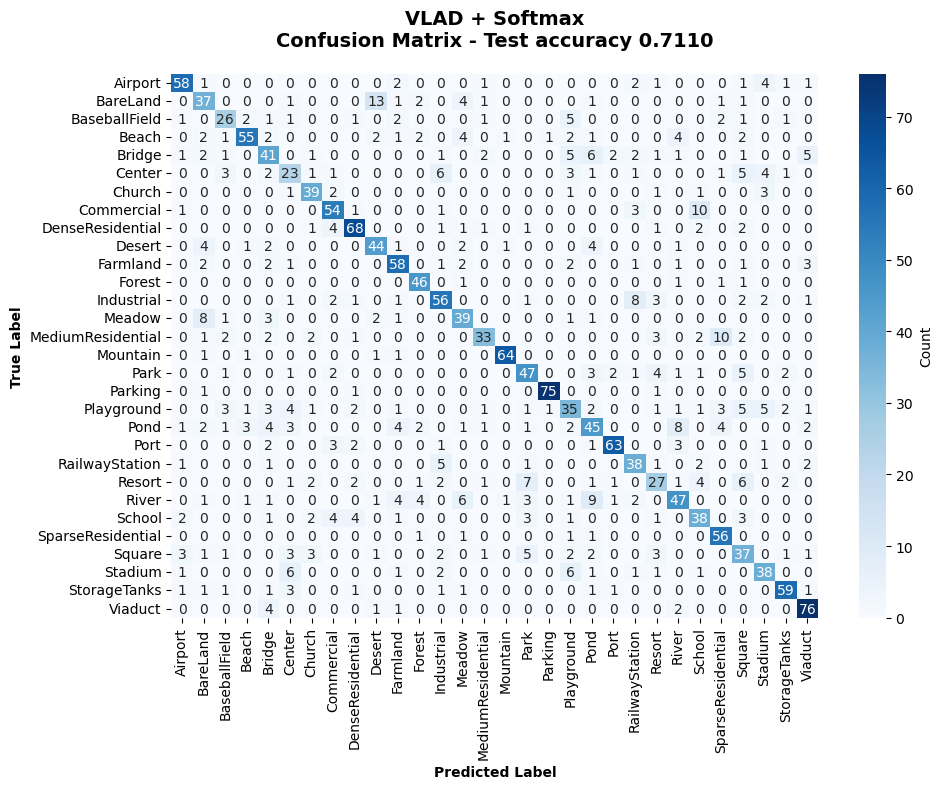

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_softmax_roc_curve.png


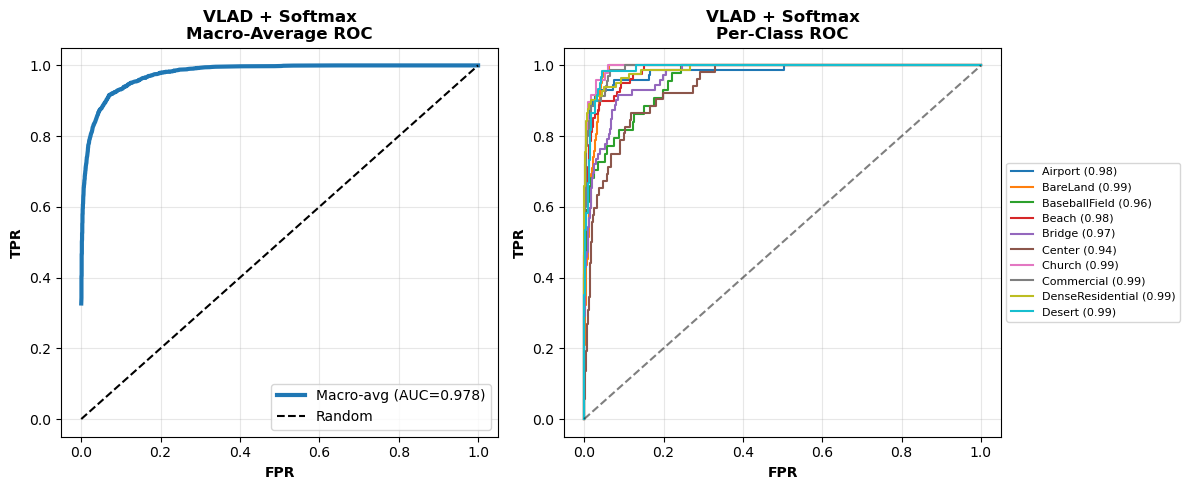


Classification Report: VLAD + Softmax

                   precision    recall  f1-score   support

          Airport     0.8286    0.8056    0.8169        72
         BareLand     0.5781    0.5968    0.5873        62
    BaseballField     0.6341    0.5909    0.6118        44
            Beach     0.8594    0.6875    0.7639        80
           Bridge     0.5694    0.5694    0.5694        72
           Center     0.4694    0.4423    0.4554        52
           Church     0.7500    0.8125    0.7800        48
       Commercial     0.7500    0.7714    0.7606        70
 DenseResidential     0.8095    0.8293    0.8193        82
           Desert     0.6769    0.7333    0.7040        60
         Farmland     0.7250    0.7838    0.7532        74
           Forest     0.7931    0.9200    0.8519        50
       Industrial     0.7089    0.7179    0.7134        78
           Meadow     0.6290    0.6964    0.6610        56
MediumResidential     0.7674    0.5690    0.6535        58
         Mounta

In [ ]:
from sklearn.linear_model import LogisticRegression

clustering_vlad_softmax = MiniBatchKMeansClustering(
    n_clusters=32,
    batch_size=10000
)

clustering_vlad_softmax.fit_iterative(
    data_loader=X_train,
    load_func=sift.load_descriptors
)

vlad_softmax = create_vlad_pipeline(
    clustering=clustering_vlad_softmax,
    descriptor_extractor=sift.load_descriptors
)

vlad_softmax_pipeline = Pipeline([
        ('encoding', vlad_softmax),
        ('classifier', LogisticRegression(
            solver='lbfgs',
            max_iter=130,
            C=8
            # note that multi_class='multinomial' is default in recent sklearn versions when n_classes > 3
))
])

# Note with softmax and vlad, higher vlad clustering gives same results but with lower C parameter
# Meaning that as long as you choose good small cluster and increase C all will reach similar results, it is like it is upper bounded
# In that case is just better to choose the smaller cluster that achieves that (less memory and faster)

results_vlad_softmax = evaluate_model(
        vlad_softmax_pipeline,
        model_name="VLAD + Softmax",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=models_dir + "/vlad_softmax.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_vlad_softmax, save_path="metrics/vlad_softmax_confusion_matrix.png")
plot_roc_curve(results_vlad_softmax, save_path="metrics/vlad_softmax_roc_curve.png")
print_classification_report(results_vlad_softmax)

### Decisition Tree


Training: BoVW + Decision Tree
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 67.99s

────────────────────────────────────────────────────────────
  BoVW + Decision Tree - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9996
  Test Acc:    0.2825
  Precision:   0.2853
  Recall:      0.2792
  F1:          0.2813
  ROC-AUC:     0.6272
  Overfit:     0.7171
  Train Time:  67.99s
  Inference:   72.178ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/bovw_dt.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/bovw_dt_confusion_matrix.png


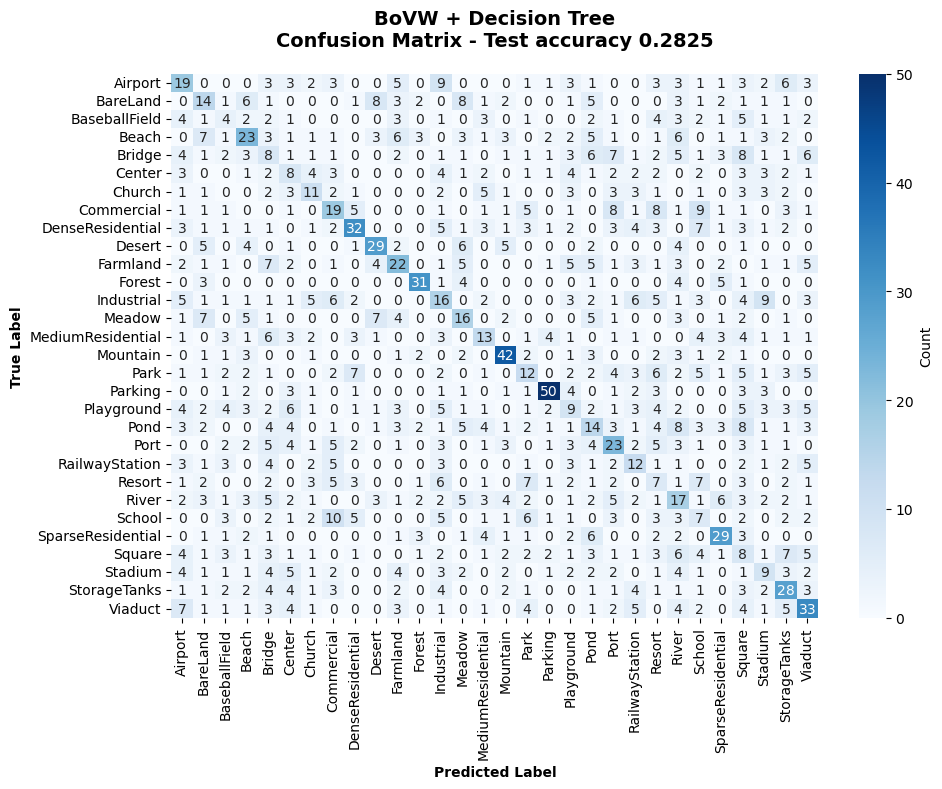

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/bovw_dt_roc_curve.png


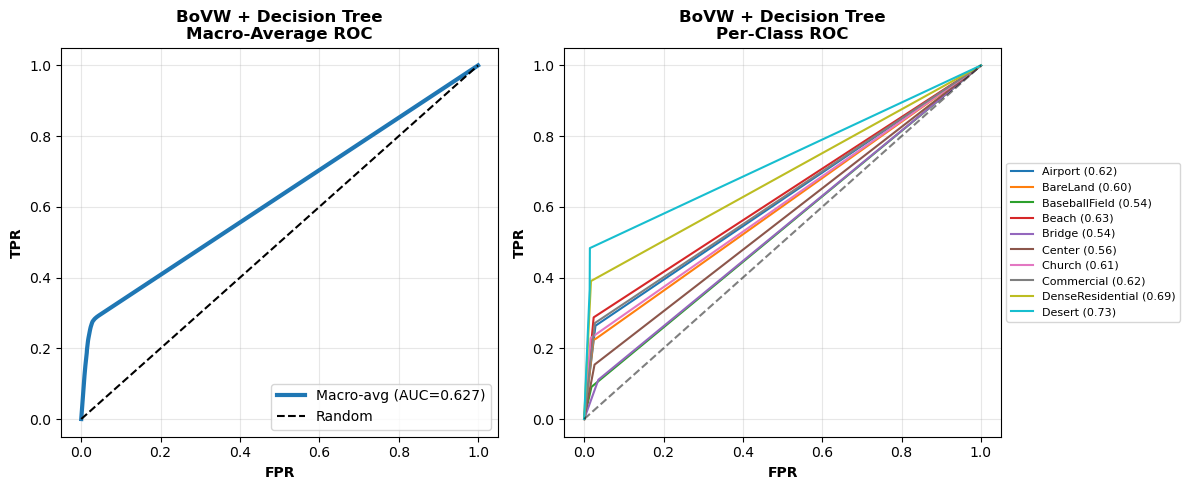


Classification Report: BoVW + Decision Tree

                   precision    recall  f1-score   support

          Airport     0.2568    0.2639    0.2603        72
         BareLand     0.2333    0.2258    0.2295        62
    BaseballField     0.1000    0.0909    0.0952        44
            Beach     0.3333    0.2875    0.3087        80
           Bridge     0.1039    0.1111    0.1074        72
           Center     0.1356    0.1538    0.1441        52
           Church     0.2558    0.2292    0.2418        48
       Commercial     0.2676    0.2714    0.2695        70
 DenseResidential     0.4923    0.3902    0.4354        82
           Desert     0.5088    0.4833    0.4957        60
         Farmland     0.3333    0.2973    0.3143        74
           Forest     0.6596    0.6200    0.6392        50
       Industrial     0.1951    0.2051    0.2000        78
           Meadow     0.2581    0.2857    0.2712        56
MediumResidential     0.2653    0.2241    0.2430        58
         

In [24]:
from sklearn.tree import DecisionTreeClassifier

bovw_dt_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', DecisionTreeClassifier(
            random_state=42
        ))
])

results_bovw_dt = evaluate_model(
        bovw_dt_pipeline,
        model_name="BoVW + Decision Tree",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=models_dir + "/bovw_dt.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_bovw_dt, save_path="metrics/bovw_dt_confusion_matrix.png")
plot_roc_curve(results_bovw_dt, save_path="metrics/bovw_dt_roc_curve.png")
print_classification_report(results_bovw_dt)


Training: VLAD + Decision Tree
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 68.01s

────────────────────────────────────────────────────────────
  VLAD + Decision Tree - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9996
  Test Acc:    0.2960
  Precision:   0.3001
  Recall:      0.2901
  F1:          0.2937
  ROC-AUC:     0.6329
  Overfit:     0.7036
  Train Time:  68.01s
  Inference:   93.570ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_dt.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_dt_confusion_matrix.png


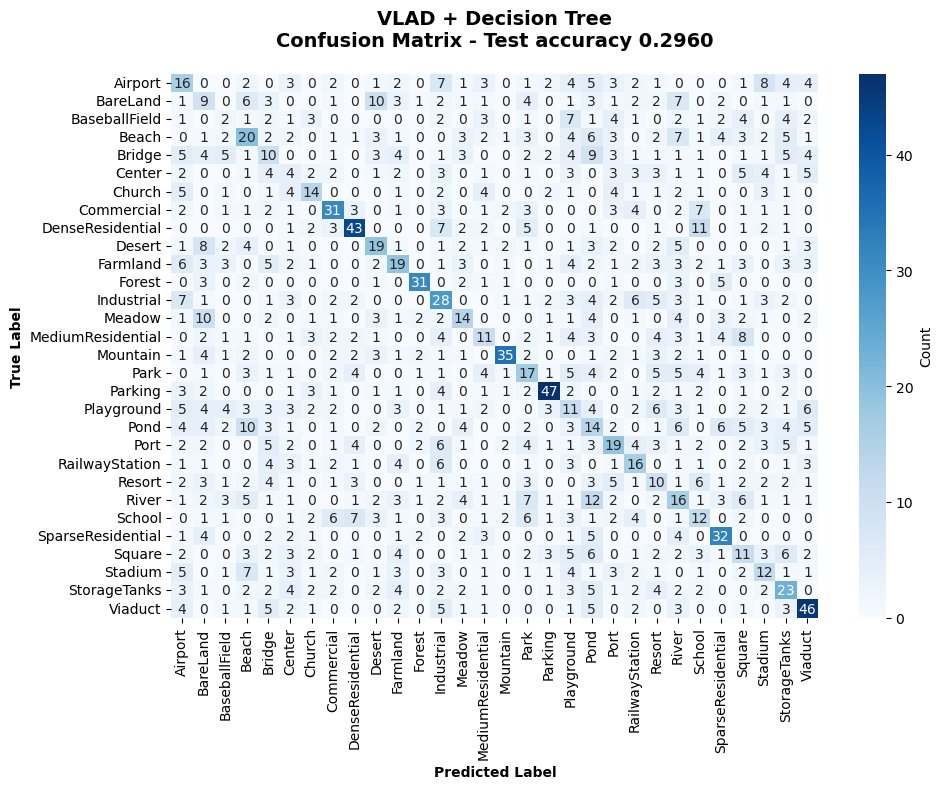

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_dt_roc_curve.png


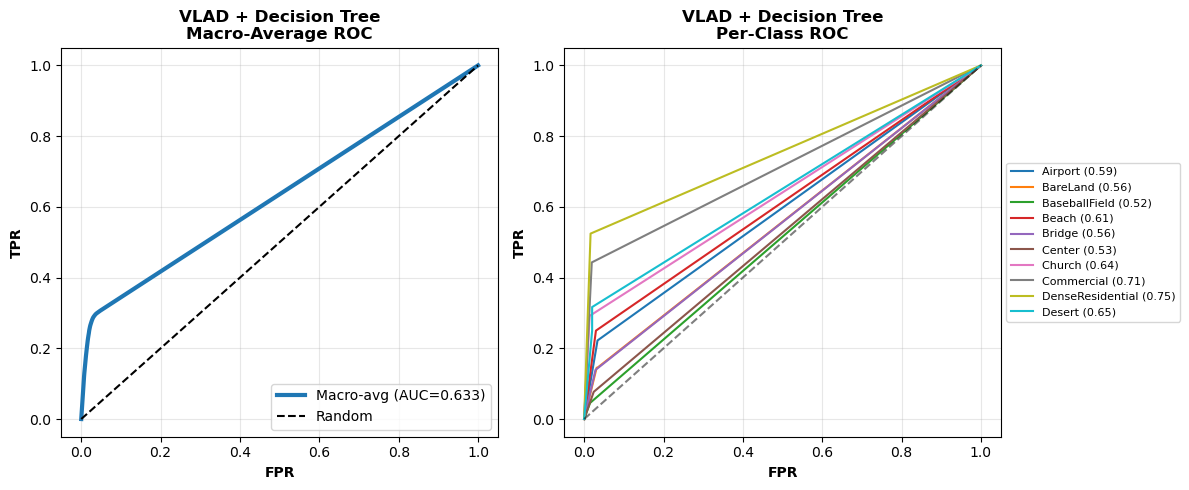


Classification Report: VLAD + Decision Tree

                   precision    recall  f1-score   support

          Airport     0.1975    0.2222    0.2092        72
         BareLand     0.1286    0.1452    0.1364        62
    BaseballField     0.0645    0.0455    0.0533        44
            Beach     0.2597    0.2500    0.2548        80
           Bridge     0.1538    0.1389    0.1460        72
           Center     0.0784    0.0769    0.0777        52
           Church     0.3415    0.2917    0.3146        48
       Commercial     0.4559    0.4429    0.4493        70
 DenseResidential     0.5811    0.5244    0.5513        82
           Desert     0.3276    0.3167    0.3220        60
         Farmland     0.3065    0.2568    0.2794        74
           Forest     0.6889    0.6200    0.6526        50
       Industrial     0.2857    0.3590    0.3182        78
           Meadow     0.2857    0.2500    0.2667        56
MediumResidential     0.2340    0.1897    0.2095        58
         

In [27]:
from sklearn.tree import DecisionTreeClassifier

vlad_dt_pipeline = Pipeline([
        ('encoding', vlad),
        ('classifier', DecisionTreeClassifier(
            random_state=42
        ))
])

results_vlad_dt = evaluate_model(
        vlad_dt_pipeline,
        model_name="VLAD + Decision Tree",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=models_dir + "/vlad_dt.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_vlad_dt, save_path="metrics/vlad_dt_confusion_matrix.png")
plot_roc_curve(results_vlad_dt, save_path="metrics/vlad_dt_roc_curve.png")
print_classification_report(results_vlad_dt)

### Random Forest


Training: BoVW + Random Forest
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 69.52s

────────────────────────────────────────────────────────────
  BoVW + Random Forest - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9989
  Test Acc:    0.5030
  Precision:   0.4835
  Recall:      0.4968
  F1:          0.4770
  ROC-AUC:     0.9059
  Overfit:     0.4959
  Train Time:  69.52s
  Inference:   73.594ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/bovw_rf.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/bovw_rf_confusion_matrix.png


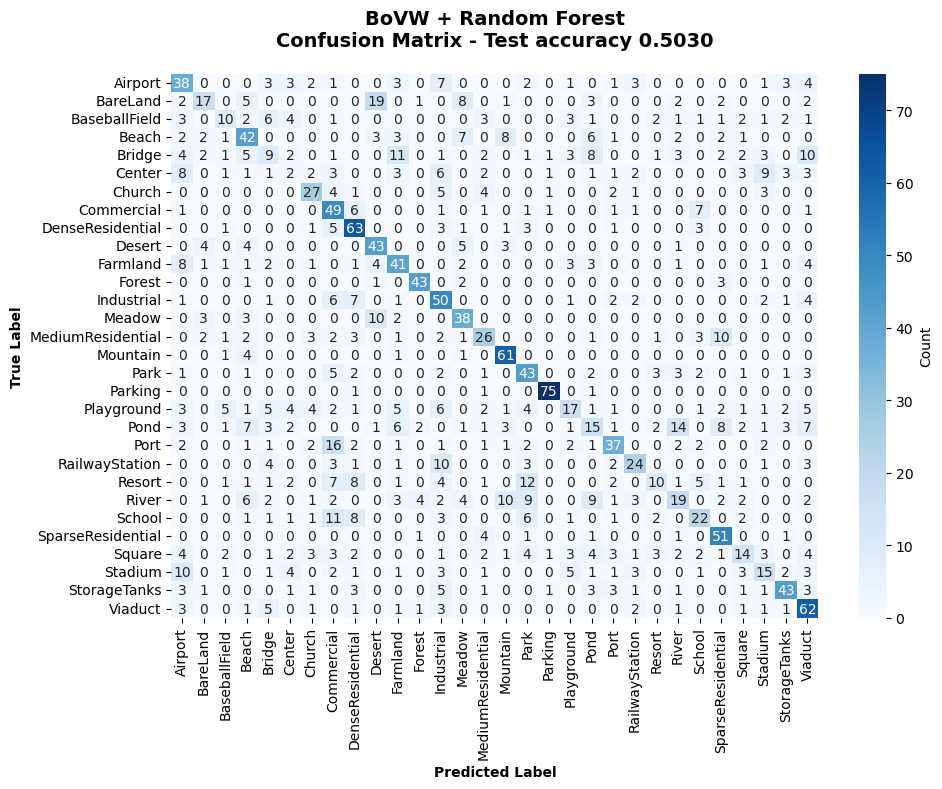

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/bovw_rf_roc_curve.png


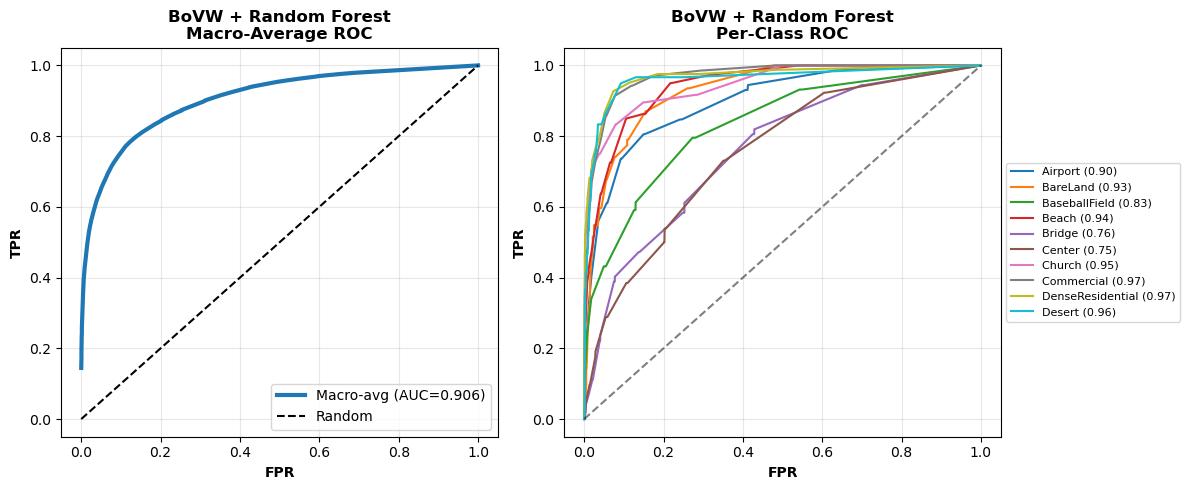


Classification Report: BoVW + Random Forest

                   precision    recall  f1-score   support

          Airport     0.3958    0.5278    0.4524        72
         BareLand     0.5152    0.2742    0.3579        62
    BaseballField     0.3704    0.2273    0.2817        44
            Beach     0.4719    0.5250    0.4970        80
           Bridge     0.1957    0.1250    0.1525        72
           Center     0.0741    0.0385    0.0506        52
           Church     0.5510    0.5625    0.5567        48
       Commercial     0.3984    0.7000    0.5078        70
 DenseResidential     0.5676    0.7683    0.6528        82
           Desert     0.5309    0.7167    0.6099        60
         Farmland     0.4824    0.5541    0.5157        74
           Forest     0.8269    0.8600    0.8431        50
       Industrial     0.4348    0.6410    0.5181        78
           Meadow     0.5429    0.6786    0.6032        56
MediumResidential     0.4906    0.4483    0.4685        58
         

In [26]:
from sklearn.ensemble import RandomForestClassifier

bovw_rf_pipeline = Pipeline([
        ('encoding', bovw),
        # There is no point in having a high number of forest when it will overfit and not increase performance
        # You would be simply increasing training time and memory of pipeline
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, max_depth=30))
])

results_bovw_rf = evaluate_model(
        bovw_rf_pipeline,
        model_name="BoVW + Random Forest",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/bovw_rf.pkl",
        save_func=sift.extract_from_file
        ) #05030
plot_confusion_matrix(results_bovw_rf, save_path="metrics/bovw_rf_confusion_matrix.png")
plot_roc_curve(results_bovw_rf, save_path="metrics/bovw_rf_roc_curve.png")
print_classification_report(results_bovw_rf)


Training: VLAD + Random Forest
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 65.89s

────────────────────────────────────────────────────────────
  VLAD + Random Forest - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9996
  Test Acc:    0.5460
  Precision:   0.5344
  Recall:      0.5371
  F1:          0.5251
  ROC-AUC:     0.9194
  Overfit:     0.4536
  Train Time:  65.89s
  Inference:   66.930ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_rf.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_rf_confusion_matrix.png


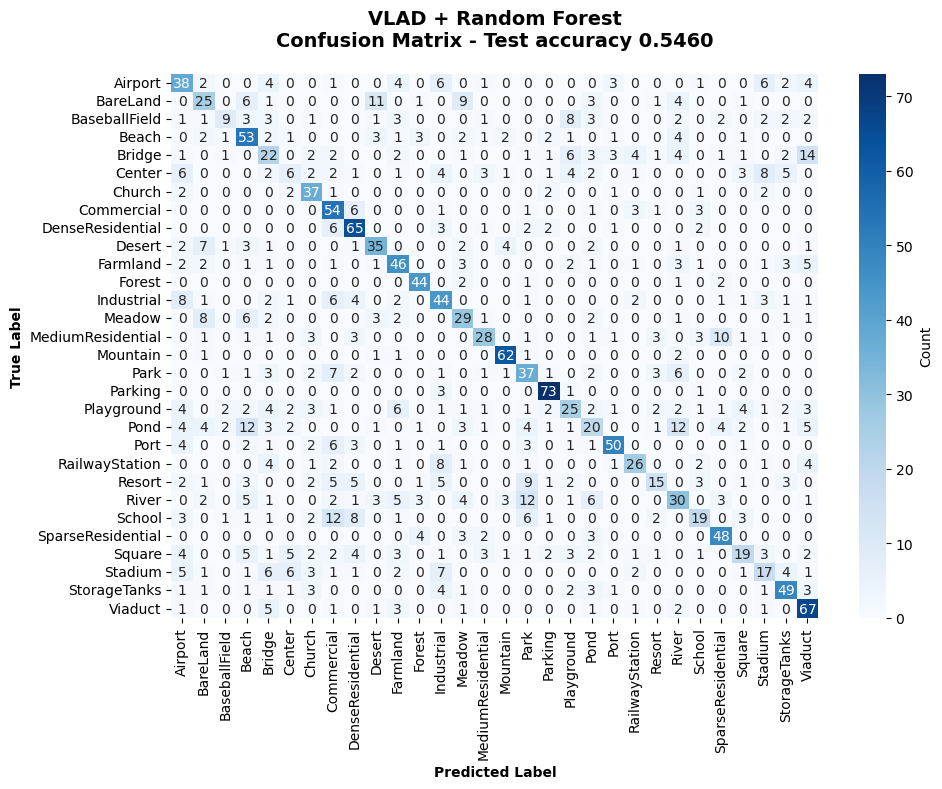

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_rf_roc_curve.png


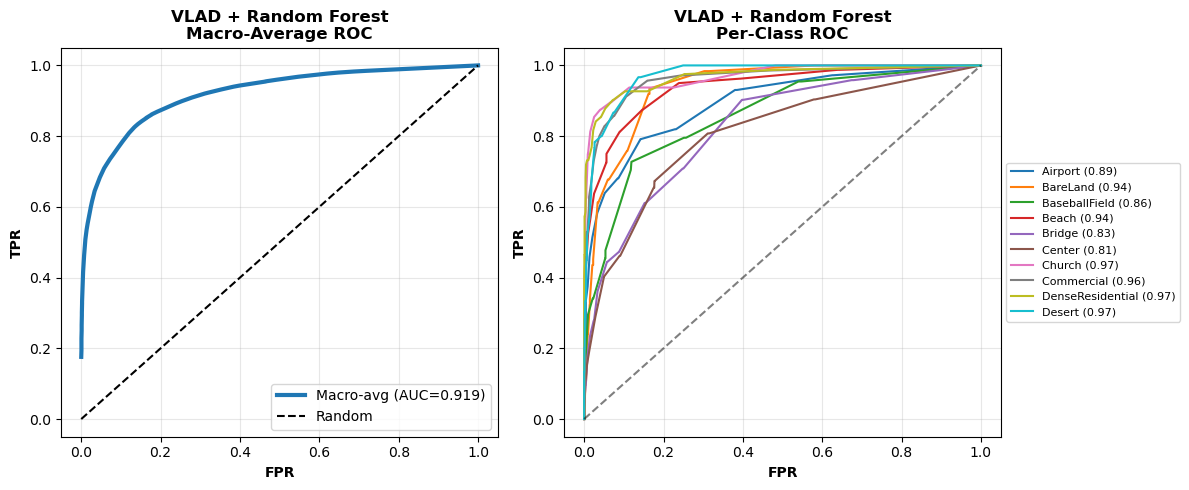


Classification Report: VLAD + Random Forest

                   precision    recall  f1-score   support

          Airport     0.4318    0.5278    0.4750        72
         BareLand     0.4237    0.4032    0.4132        62
    BaseballField     0.5000    0.2045    0.2903        44
            Beach     0.5000    0.6625    0.5699        80
           Bridge     0.3099    0.3056    0.3077        72
           Center     0.2308    0.1154    0.1538        52
           Church     0.5692    0.7708    0.6549        48
       Commercial     0.4821    0.7714    0.5934        70
 DenseResidential     0.6250    0.7927    0.6989        82
           Desert     0.5833    0.5833    0.5833        60
         Farmland     0.5476    0.6216    0.5823        74
           Forest     0.7719    0.8800    0.8224        50
       Industrial     0.4944    0.5641    0.5269        78
           Meadow     0.4677    0.5179    0.4915        56
MediumResidential     0.6364    0.4828    0.5490        58
         

In [28]:
from sklearn.ensemble import RandomForestClassifier

vlad_rf_pipeline = Pipeline([
        ('encoding', vlad),
        # There is no point in having a high number of forest when it will overfit and not increase performance
        # You would be simply increasing training time and memory of pipeline
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, max_depth=30))
])

results_vlad_rf = evaluate_model(
        vlad_rf_pipeline,
        model_name="VLAD + Random Forest",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/vlad_rf.pkl",
        save_func=sift.extract_from_file
        ) #05030
plot_confusion_matrix(results_vlad_rf, save_path="metrics/vlad_rf_confusion_matrix.png")
plot_roc_curve(results_vlad_rf, save_path="metrics/vlad_rf_roc_curve.png")
print_classification_report(results_vlad_rf)

### Support Vector Machine


Training: BoVW + Support Vector Classifier (Linear)
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 78.68s

────────────────────────────────────────────────────────────
  BoVW + Support Vector Classifier (Linear) - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9245
  Test Acc:    0.6485
  Precision:   0.6408
  Recall:      0.6435
  F1:          0.6386
  ROC-AUC:     0.9689
  Overfit:     0.2760
  Train Time:  78.68s
  Inference:   83.458ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/bovw_svc_lin.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/bovw_svc_lin_confusion_matrix.png


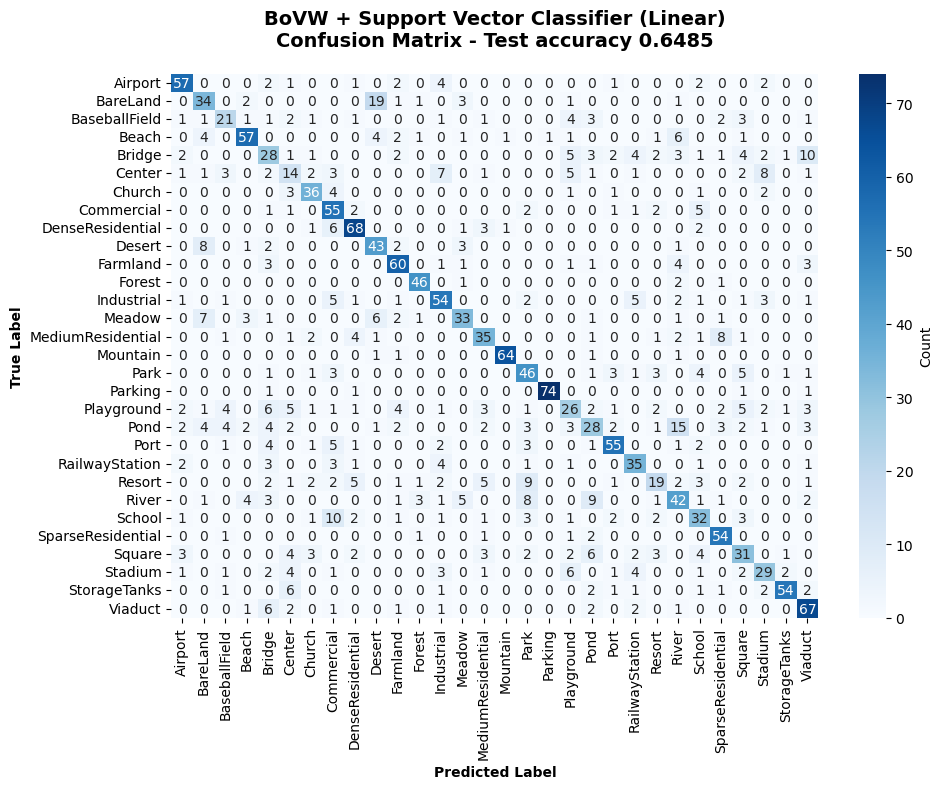

/tmp/ipykernel_41177/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_41177/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/bovw_svc_lin_roc_curve.png


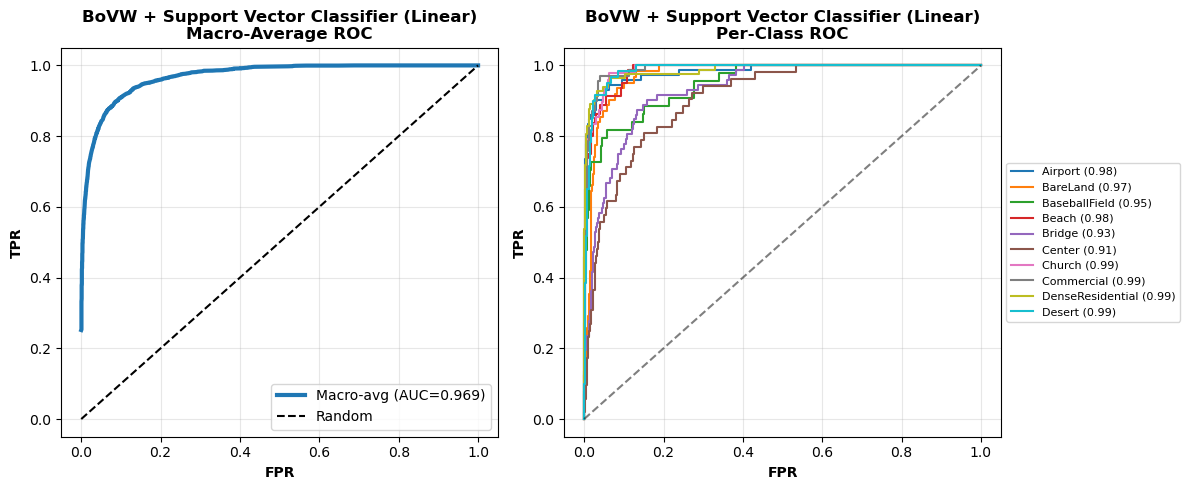


Classification Report: BoVW + Support Vector Classifier (Linear)

                   precision    recall  f1-score   support

          Airport     0.7808    0.7917    0.7862        72
         BareLand     0.5574    0.5484    0.5528        62
    BaseballField     0.5526    0.4773    0.5122        44
            Beach     0.8028    0.7125    0.7550        80
           Bridge     0.3889    0.3889    0.3889        72
           Center     0.2979    0.2692    0.2828        52
           Church     0.6923    0.7500    0.7200        48
       Commercial     0.5556    0.7857    0.6509        70
 DenseResidential     0.7556    0.8293    0.7907        82
           Desert     0.5733    0.7167    0.6370        60
         Farmland     0.7229    0.8108    0.7643        74
           Forest     0.8519    0.9200    0.8846        50
       Industrial     0.6506    0.6923    0.6708        78
           Meadow     0.6875    0.5893    0.6346        56
MediumResidential     0.6250    0.6034    0.614

In [ ]:
from sklearn.svm import SVC
# Use in sklearn Pipeline
bovw_svc_lin_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', SVC(kernel='linear', C=10, probability=True))
])

results_bovw_svc_lin = evaluate_model(
        bovw_svc_lin_pipeline,
        model_name="BoVW + Support Vector Classifier (Linear)",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/bovw_svc_lin.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_bovw_svc_lin, save_path="metrics/bovw_svc_lin_confusion_matrix.png")
plot_roc_curve(results_bovw_svc_lin, save_path="metrics/bovw_svc_lin_roc_curve.png")
print_classification_report(results_bovw_svc_lin)


Training: VLAD + Support Vector Classifier (Linear)
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 79.35s

────────────────────────────────────────────────────────────
  VLAD + Support Vector Classifier (Linear) - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9375
  Test Acc:    0.6760
  Precision:   0.6701
  Recall:      0.6696
  F1:          0.6669
  ROC-AUC:     0.9751
  Overfit:     0.2615
  Train Time:  79.35s
  Inference:   84.331ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_svc_lin.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_svc_lin_confusion_matrix.png


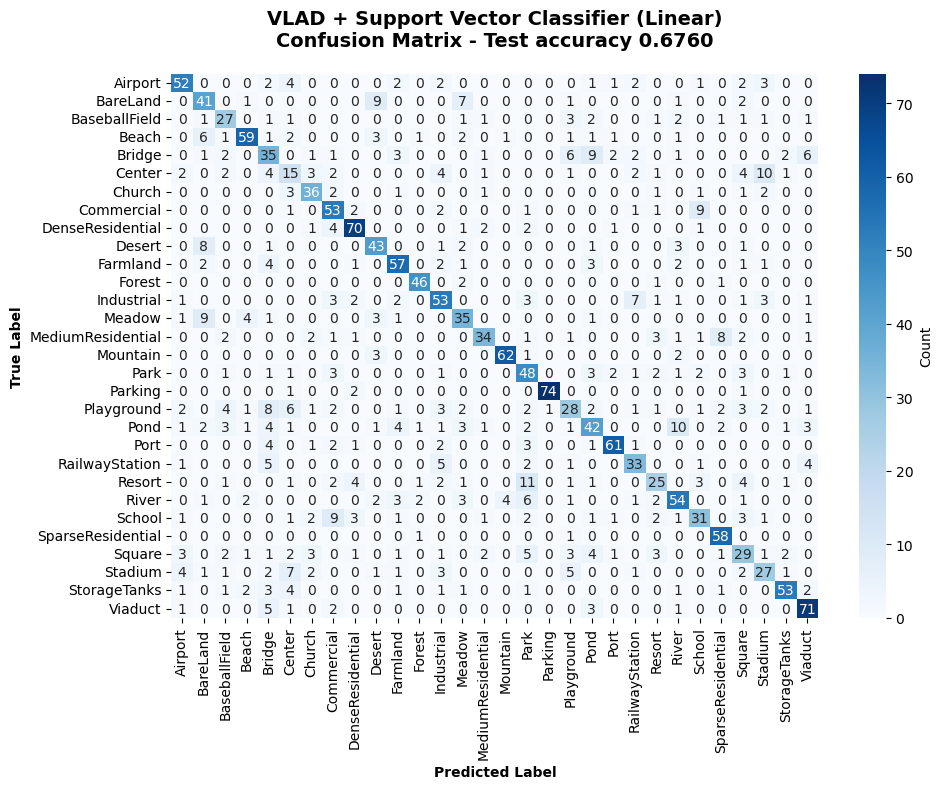

/tmp/ipykernel_41177/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_41177/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_svc_lin_roc_curve.png


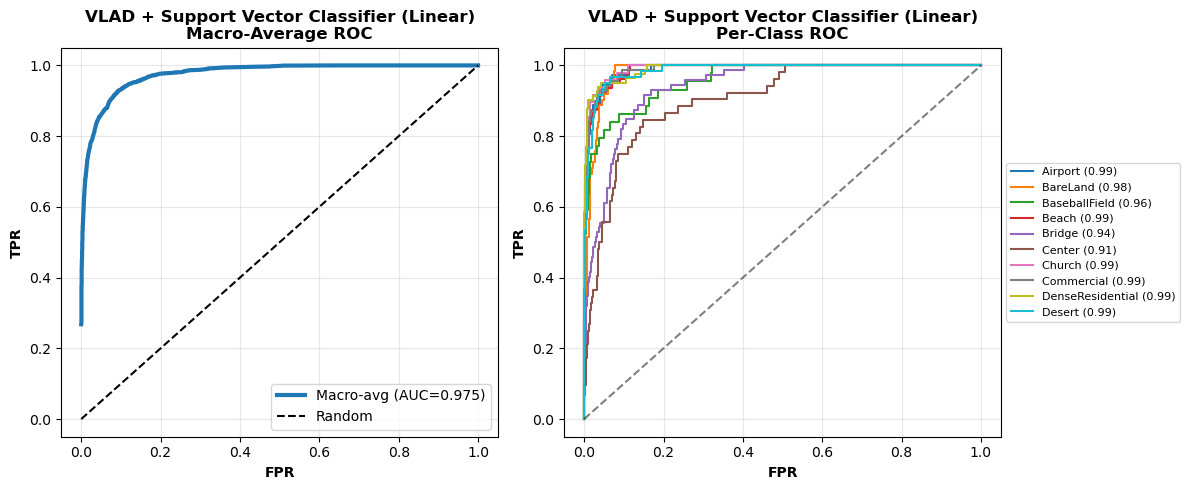


Classification Report: VLAD + Support Vector Classifier (Linear)

                   precision    recall  f1-score   support

          Airport     0.7429    0.7222    0.7324        72
         BareLand     0.5694    0.6613    0.6119        62
    BaseballField     0.5745    0.6136    0.5934        44
            Beach     0.8310    0.7375    0.7815        80
           Bridge     0.4268    0.4861    0.4545        72
           Center     0.2941    0.2885    0.2913        52
           Church     0.6923    0.7500    0.7200        48
       Commercial     0.6163    0.7571    0.6795        70
 DenseResidential     0.8046    0.8537    0.8284        82
           Desert     0.6615    0.7167    0.6880        60
         Farmland     0.7308    0.7703    0.7500        74
           Forest     0.8846    0.9200    0.9020        50
       Industrial     0.6386    0.6795    0.6584        78
           Meadow     0.5738    0.6250    0.5983        56
MediumResidential     0.7727    0.5862    0.666

In [ ]:
from sklearn.svm import SVC
# Use in sklearn Pipeline
vlad_svc_lin_pipeline = Pipeline([
        ('encoding', vlad),
        ('classifier', SVC(kernel='linear', C=7, probability=True))
])

results_vlad_svc_lin = evaluate_model(
        vlad_svc_lin_pipeline,
        model_name="VLAD + Support Vector Classifier (Linear)",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/vlad_svc_lin.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_vlad_svc_lin, save_path="metrics/vlad_svc_lin_confusion_matrix.png")
plot_roc_curve(results_vlad_svc_lin, save_path="metrics/vlad_svc_lin_roc_curve.png")
print_classification_report(results_vlad_svc_lin)


Training: BoVW + Support Vector Classifier (RBF)
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 92.77s

────────────────────────────────────────────────────────────
  BoVW + Support Vector Classifier (RBF) - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9960
  Test Acc:    0.6825
  Precision:   0.6708
  Recall:      0.6756
  F1:          0.6696
  ROC-AUC:     0.9753
  Overfit:     0.3135
  Train Time:  92.77s
  Inference:   95.938ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/bovw_svc_rbf.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/bovw_svc_rbf_confusion_matrix.png


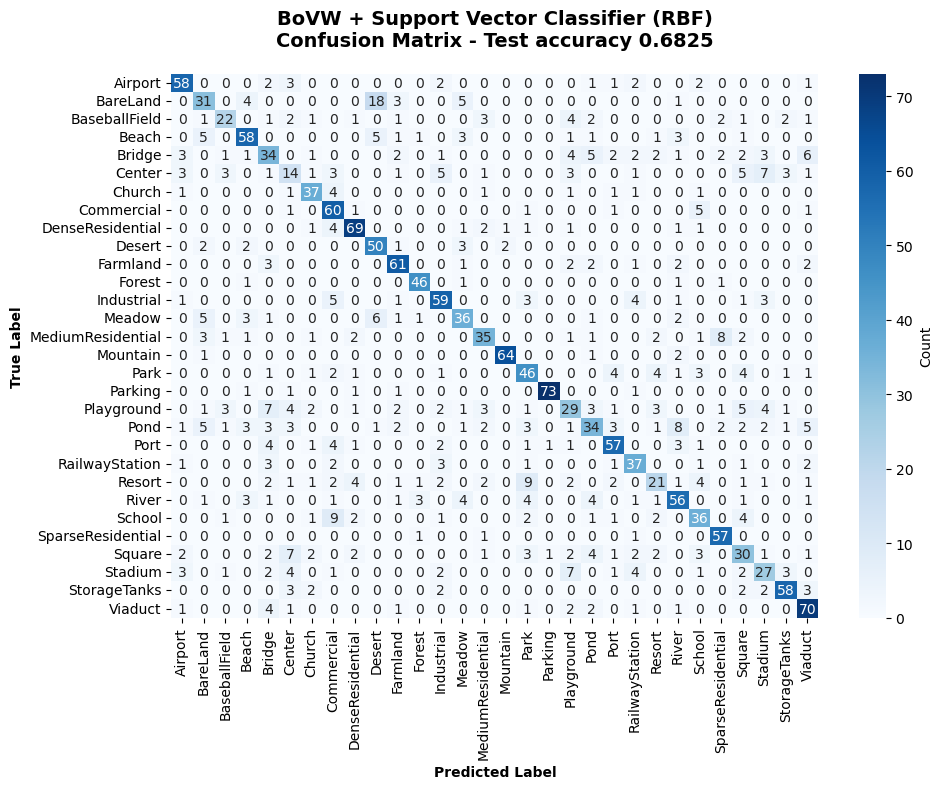

/tmp/ipykernel_41177/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_41177/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/bovw_svc_rbf_roc_curve.png


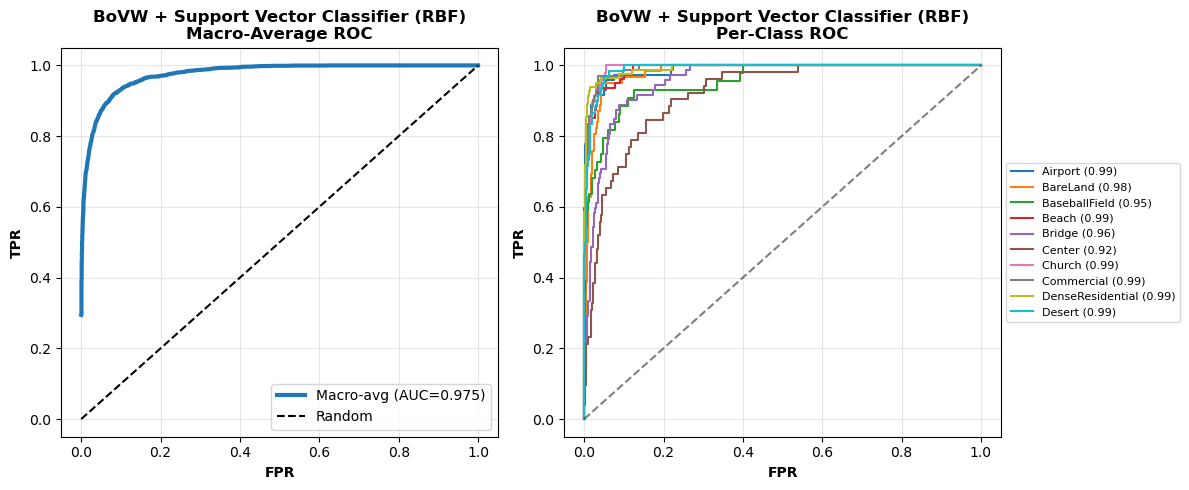


Classification Report: BoVW + Support Vector Classifier (RBF)

                   precision    recall  f1-score   support

          Airport     0.7838    0.8056    0.7945        72
         BareLand     0.5636    0.5000    0.5299        62
    BaseballField     0.6667    0.5000    0.5714        44
            Beach     0.7532    0.7250    0.7389        80
           Bridge     0.4789    0.4722    0.4755        72
           Center     0.3111    0.2692    0.2887        52
           Church     0.7115    0.7708    0.7400        48
       Commercial     0.6186    0.8571    0.7186        70
 DenseResidential     0.8118    0.8415    0.8263        82
           Desert     0.6250    0.8333    0.7143        60
         Farmland     0.7625    0.8243    0.7922        74
           Forest     0.8679    0.9200    0.8932        50
       Industrial     0.7195    0.7564    0.7375        78
           Meadow     0.6429    0.6429    0.6429        56
MediumResidential     0.6863    0.6034    0.6422  

In [14]:
from sklearn.svm import SVC
# Use in sklearn Pipeline
bovw_svc_rbf_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', SVC(kernel='rbf', C=4, gamma='scale', probability=True))
])


results_bovw_svc_rbf = evaluate_model(
        bovw_svc_rbf_pipeline,
        model_name="BoVW + Support Vector Classifier (RBF)",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/bovw_svc_rbf.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_bovw_svc_rbf, save_path="metrics/bovw_svc_rbf_confusion_matrix.png")
plot_roc_curve(results_bovw_svc_rbf, save_path="metrics/bovw_svc_rbf_roc_curve.png")
print_classification_report(results_bovw_svc_rbf)


Training: VLAD + Support Vector Classifier (RBF)
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 118.13s

────────────────────────────────────────────────────────────
  VLAD + Support Vector Classifier (RBF) - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9995
  Test Acc:    0.7185
  Precision:   0.7160
  Recall:      0.7124
  F1:          0.7111
  ROC-AUC:     0.9794
  Overfit:     0.2810
  Train Time:  118.13s
  Inference:   140.395ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_svc_rbf.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_svc_rbf_confusion_matrix.png


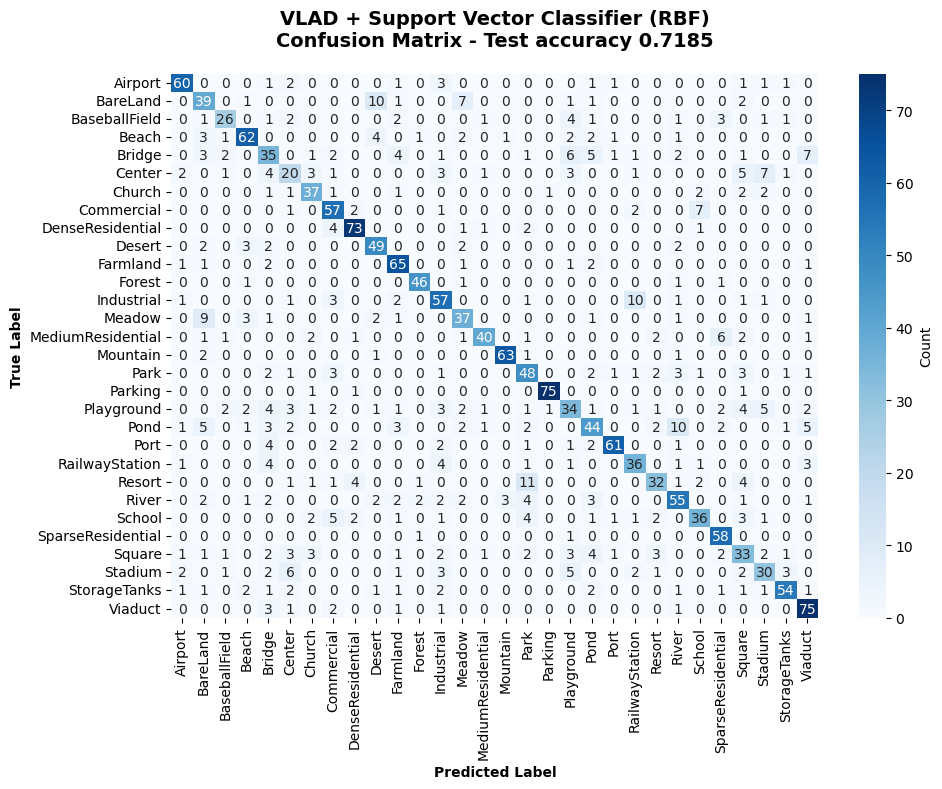

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_svc_rbf_roc_curve.png


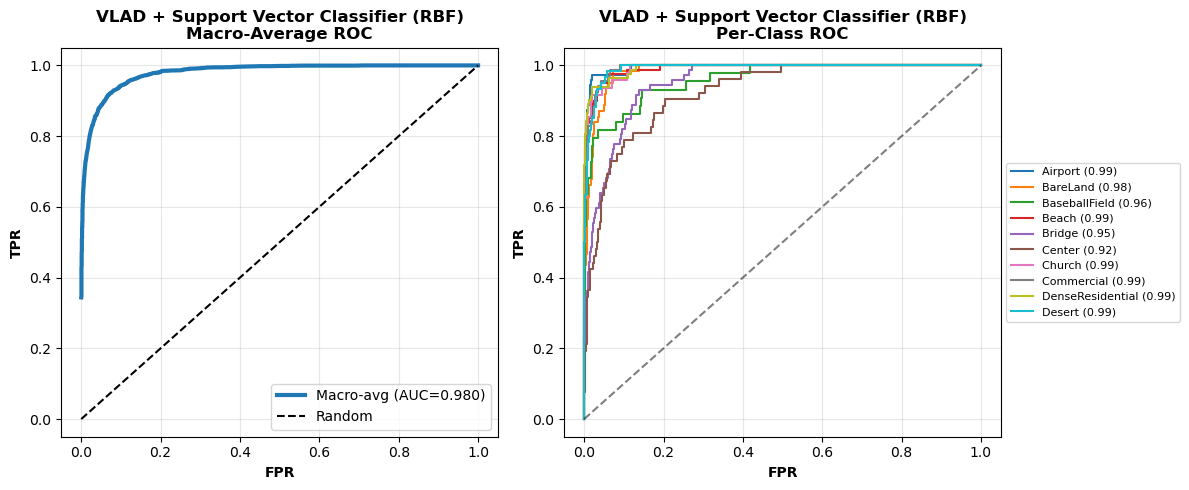


Classification Report: VLAD + Support Vector Classifier (RBF)

                   precision    recall  f1-score   support

          Airport     0.8571    0.8333    0.8451        72
         BareLand     0.5571    0.6290    0.5909        62
    BaseballField     0.7429    0.5909    0.6582        44
            Beach     0.8158    0.7750    0.7949        80
           Bridge     0.4730    0.4861    0.4795        72
           Center     0.4348    0.3846    0.4082        52
           Church     0.7255    0.7708    0.7475        48
       Commercial     0.6867    0.8143    0.7451        70
 DenseResidential     0.8588    0.8902    0.8743        82
           Desert     0.7000    0.8167    0.7538        60
         Farmland     0.7386    0.8784    0.8025        74
           Forest     0.9020    0.9200    0.9109        50
       Industrial     0.6628    0.7308    0.6951        78
           Meadow     0.6379    0.6607    0.6491        56
MediumResidential     0.8696    0.6897    0.7692  

In [33]:
from sklearn.svm import SVC
# Use in sklearn Pipeline
vlad_svc_rbf_pipeline = Pipeline([
        ('encoding', vlad),
        ('classifier', SVC(kernel='rbf', C=4, gamma='scale', probability=True))
])


results_vlad_svc_rbf = evaluate_model(
        vlad_svc_rbf_pipeline,
        model_name="VLAD + Support Vector Classifier (RBF)",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/vlad_svc_rbf.pkl",
        save_func=sift.extract_from_file
        )
plot_confusion_matrix(results_vlad_svc_rbf, save_path="metrics/vlad_svc_rbf_confusion_matrix.png")
plot_roc_curve(results_vlad_svc_rbf, save_path="metrics/vlad_svc_rbf_roc_curve.png")
print_classification_report(results_vlad_svc_rbf)

### XGBoost


Training: BoVW + Gradient Boosting
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 172.10s

────────────────────────────────────────────────────────────
  BoVW + Gradient Boosting - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9620
  Test Acc:    0.6165
  Precision:   0.6099
  Recall:      0.6106
  F1:          0.6062
  ROC-AUC:     0.9627
  Overfit:     0.3455
  Train Time:  172.10s
  Inference:   123.939ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/bovw_xgb.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/bovw_xgb_confusion_matrix.png


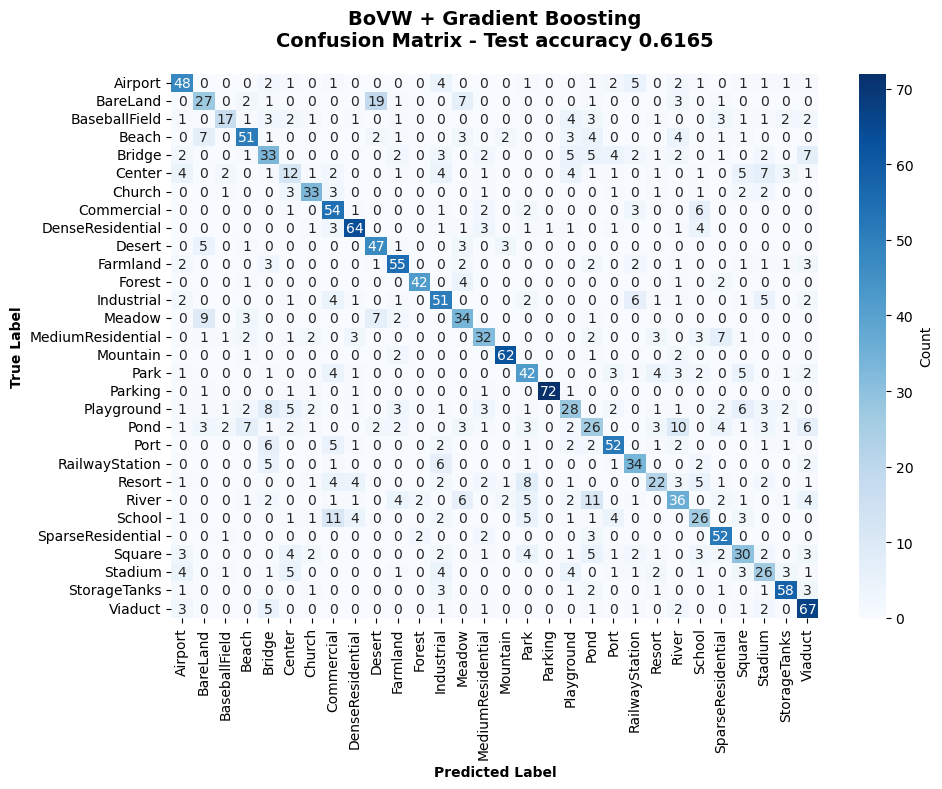

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/bovw_xgb_roc_curve.png


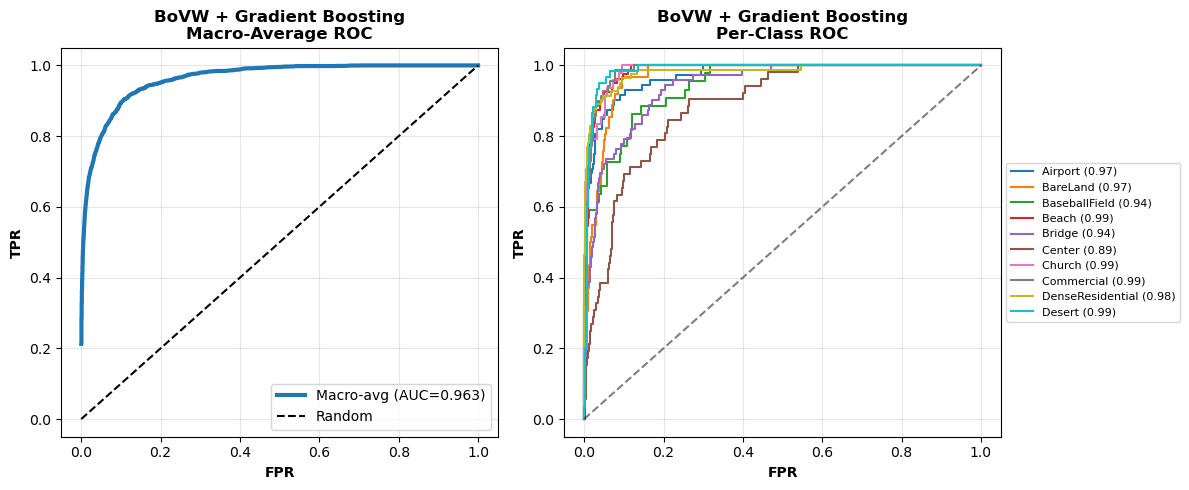


Classification Report: BoVW + Gradient Boosting

                   precision    recall  f1-score   support

          Airport     0.6400    0.6667    0.6531        72
         BareLand     0.5000    0.4355    0.4655        62
    BaseballField     0.6538    0.3864    0.4857        44
            Beach     0.6986    0.6375    0.6667        80
           Bridge     0.4521    0.4583    0.4552        72
           Center     0.3077    0.2308    0.2637        52
           Church     0.7021    0.6875    0.6947        48
       Commercial     0.5806    0.7714    0.6626        70
 DenseResidential     0.7711    0.7805    0.7758        82
           Desert     0.6026    0.7833    0.6812        60
         Farmland     0.7143    0.7432    0.7285        74
           Forest     0.9130    0.8400    0.8750        50
       Industrial     0.5862    0.6538    0.6182        78
           Meadow     0.5397    0.6071    0.5714        56
MediumResidential     0.6154    0.5517    0.5818        58
     

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import normalize
from sklearn.preprocessing import FunctionTransformer

# Note that HistGradientBoostingClassifier is faster and more efficient than XGBoost in many cases
# It is like 100x faster to train with even better results

bovw_gb_pipeline = Pipeline([
        ('encoding', bovw),
        ('classifier', HistGradientBoostingClassifier(
            learning_rate=0.2,
            max_depth=4,
            max_leaf_nodes=15,
            min_samples_leaf=20,
            l2_regularization=5.0,
            max_iter=300,
            early_stopping=True,
            random_state=42
        ))
])

results_bovw_gb = evaluate_model(
        bovw_gb_pipeline,
        model_name="BoVW + Gradient Boosting",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/bovw_xgb.pkl",
        save_func=sift.extract_from_file
        )

plot_confusion_matrix(results_bovw_gb, save_path="metrics/bovw_xgb_confusion_matrix.png")
plot_roc_curve(results_bovw_gb, save_path="metrics/bovw_xgb_roc_curve.png")
print_classification_report(results_bovw_gb)


Training: VLAD + Gradient Boosting
Skipping clustering fit (using pre-fitted clusters)
✓ Trained in 129.45s

────────────────────────────────────────────────────────────
  VLAD + Gradient Boosting - Summary
────────────────────────────────────────────────────────────
  Train Acc:   0.9996
  Test Acc:    0.6555
  Precision:   0.6469
  Recall:      0.6427
  F1:          0.6394
  ROC-AUC:     0.9613
  Overfit:     0.3441
  Train Time:  129.45s
  Inference:   99.382ms/sample
────────────────────────────────────────────────────────────

✓ Updated descriptor extractor to extract_from_file
✓ Model saved to models/vlad_xgb.pkl
✓ Restored original descriptor extractor.
✓ Saved to metrics/vlad_xgb_confusion_matrix.png


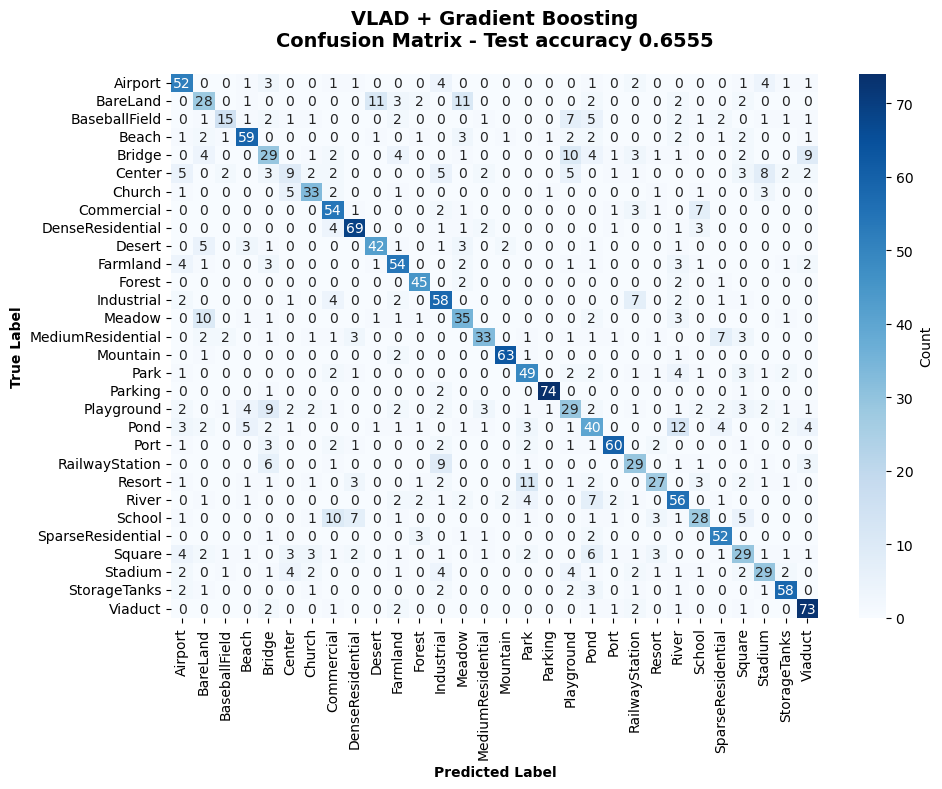

/tmp/ipykernel_363957/2546382359.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  macro_auc = np.trapz(mean_tpr, all_fpr)
/tmp/ipykernel_363957/2546382359.py:209: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_i = np.trapz(tpr[i], fpr[i])


✓ Saved to metrics/vlad_xgb_roc_curve.png


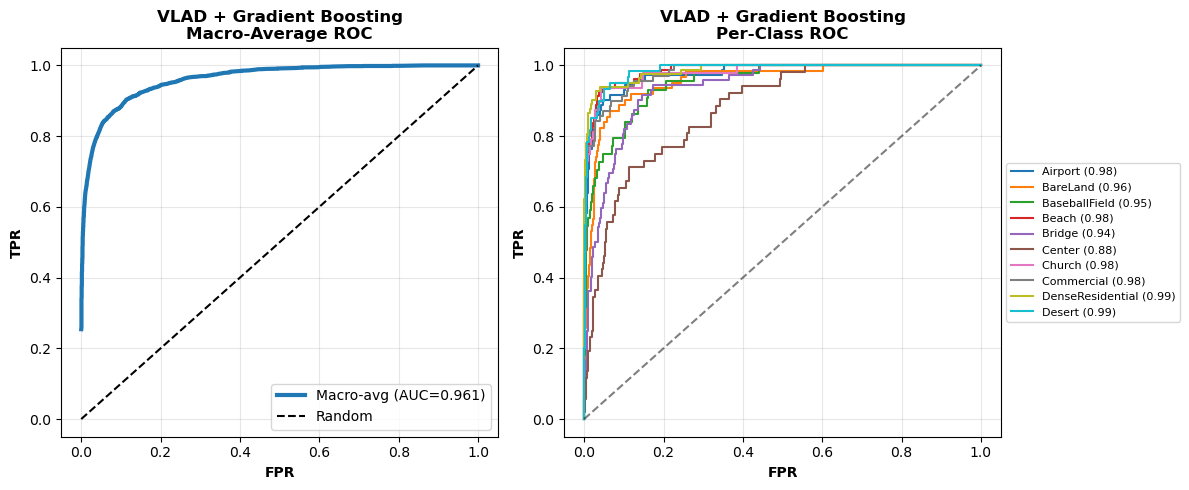


Classification Report: BoVW + Gradient Boosting

                   precision    recall  f1-score   support

          Airport     0.6400    0.6667    0.6531        72
         BareLand     0.5000    0.4355    0.4655        62
    BaseballField     0.6538    0.3864    0.4857        44
            Beach     0.6986    0.6375    0.6667        80
           Bridge     0.4521    0.4583    0.4552        72
           Center     0.3077    0.2308    0.2637        52
           Church     0.7021    0.6875    0.6947        48
       Commercial     0.5806    0.7714    0.6626        70
 DenseResidential     0.7711    0.7805    0.7758        82
           Desert     0.6026    0.7833    0.6812        60
         Farmland     0.7143    0.7432    0.7285        74
           Forest     0.9130    0.8400    0.8750        50
       Industrial     0.5862    0.6538    0.6182        78
           Meadow     0.5397    0.6071    0.5714        56
MediumResidential     0.6154    0.5517    0.5818        58
     

In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier

# clustering_vlad = MiniBatchKMeansClustering(
#     n_clusters=8, #32 06410  16 06665
#     batch_size=10000
# )

# clustering_vlad.fit_iterative(
#     data_loader=X_train,
#     load_func=sift.load_descriptors
# )

# vlad = create_vlad_pipeline(
#     clustering=clustering_vlad,
#     descriptor_extractor=sift.load_descriptors
# )

vlad_gb_pipeline = Pipeline([
        ('encoding', vlad),
        ('classifier', HistGradientBoostingClassifier(
            learning_rate=0.1,
        #     max_depth=5,
            random_state=42
        ))
])

results_vlad_gb = evaluate_model(
        vlad_gb_pipeline,
        model_name="VLAD + Gradient Boosting",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        le=le,
        verbose=True,
        save_model_path=f"{models_dir}/vlad_xgb.pkl",
        save_func=sift.extract_from_file
        )

plot_confusion_matrix(results_vlad_gb, save_path="metrics/vlad_xgb_confusion_matrix.png")
plot_roc_curve(results_vlad_gb, save_path="metrics/vlad_xgb_roc_curve.png")
print_classification_report(results_bovw_gb)

# Convolutional Neural Network

In [ ]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)  # Add skip connection
        out = self.relu(out)

        return out


class PiattiCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # Initial conv
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(64, 64),
            nn.MaxPool2d(2),

            ResidualBlock(64, 128, stride=1),
            nn.MaxPool2d(2),

            ResidualBlock(128, 256, stride=1),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Prettier visuals for loops
import os

# Set environment variable before anything else
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear any existing CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    epoch_acc = 100. * train_correct / train_total
    return train_loss / len(train_loader), epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_acc = 100. * val_correct / val_total
    return val_loss / len(val_loader), epoch_acc


# Transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2),
])

# Load dataset
dataset = datasets.ImageFolder(root='data/train', transform=transform_train)
print(f'Classes: {dataset.classes}')

# Split
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, random_state=0, stratify=dataset.targets
)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f'Training: {len(train_dataset)}, Validation: {len(val_dataset)}')

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PiattiCNN(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Training loop
num_epochs = 100
best_val_acc = 0

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step()

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'num_params': num_params,
            'num_classes': len(dataset.classes),
            'class_names': dataset.classes,
        }, f'PiattiVL-{num_params//1000}kresnet.pth')
        print(f'✓ Saved best model: {val_acc:.2f}%')

print(f'\nBest validation accuracy: {best_val_acc:.2f}%')


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

def count_parameters(model):
    """Count trainable parameters"""
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total

def format_parameter_count(count):
    """Format parameter count (e.g., 1.2M, 345K)"""
    if count >= 1e6:
        return f"{count/1e6:.2f}M"
    elif count >= 1e3:
        return f"{count/1e3:.2f}K"
    else:
        return str(count)

def test_model(model, test_loader, device, class_names):
    """Evaluate model on test set with comprehensive metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100. * correct / total
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Print results
    print("\n" + "="*60)
    print("TEST SET RESULTS")
    print("="*60)
    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Macro Precision:  {precision:.4f}")
    print(f"Macro Recall:     {recall:.4f}")
    print(f"Macro F1-Score:   {f1:.4f}")
    print(f"\nTotal Samples:    {total}")
    print(f"Correct Predictions: {correct}")
    print(f"Incorrect Predictions: {total - correct}")

    # Detailed classification report
    print("\n" + "-"*60)
    print("PER-CLASS METRICS")
    print("-"*60)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Convolutional Neural Network\nConfusion Matrix - Test Accuracy: {accuracy:.2f}%')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("\n✓ Confusion matrix saved to 'confusion_matrix.png'")

    return accuracy, all_preds, all_labels, precision, recall, f1

# Note that test transformation are consistent and reproducible (deterministic)
# No random, no flip, no jitter (different from training)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(root='data/test', transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}\n")

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PiattiCNN(num_classes=len(test_dataset.classes)).to(device)

# Load checkpoint
checkpoint = torch.load('PiattiVL-1232kresnet.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Count parameters
num_params = count_parameters(model)
print(f"Model: PiattiCNN")
print(f"Parameters: {format_parameter_count(num_params)} ({num_params:,})")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Trained for {checkpoint['epoch']+1} epochs\n")

# Test
test_accuracy, preds, labels, precision, recall, f1 = test_model(model, test_loader, device, test_dataset.classes)

print(f"\n{'='*60}")
print(f"FINAL TEST ACCURACY: {test_accuracy:.2f}%")
print(f"{'='*60}\n")